[Integrating BigQuery ML with Dialogflow ES Chatbot](https://www.cloudskillsboost.google/focuses/4414?parent=catalog)

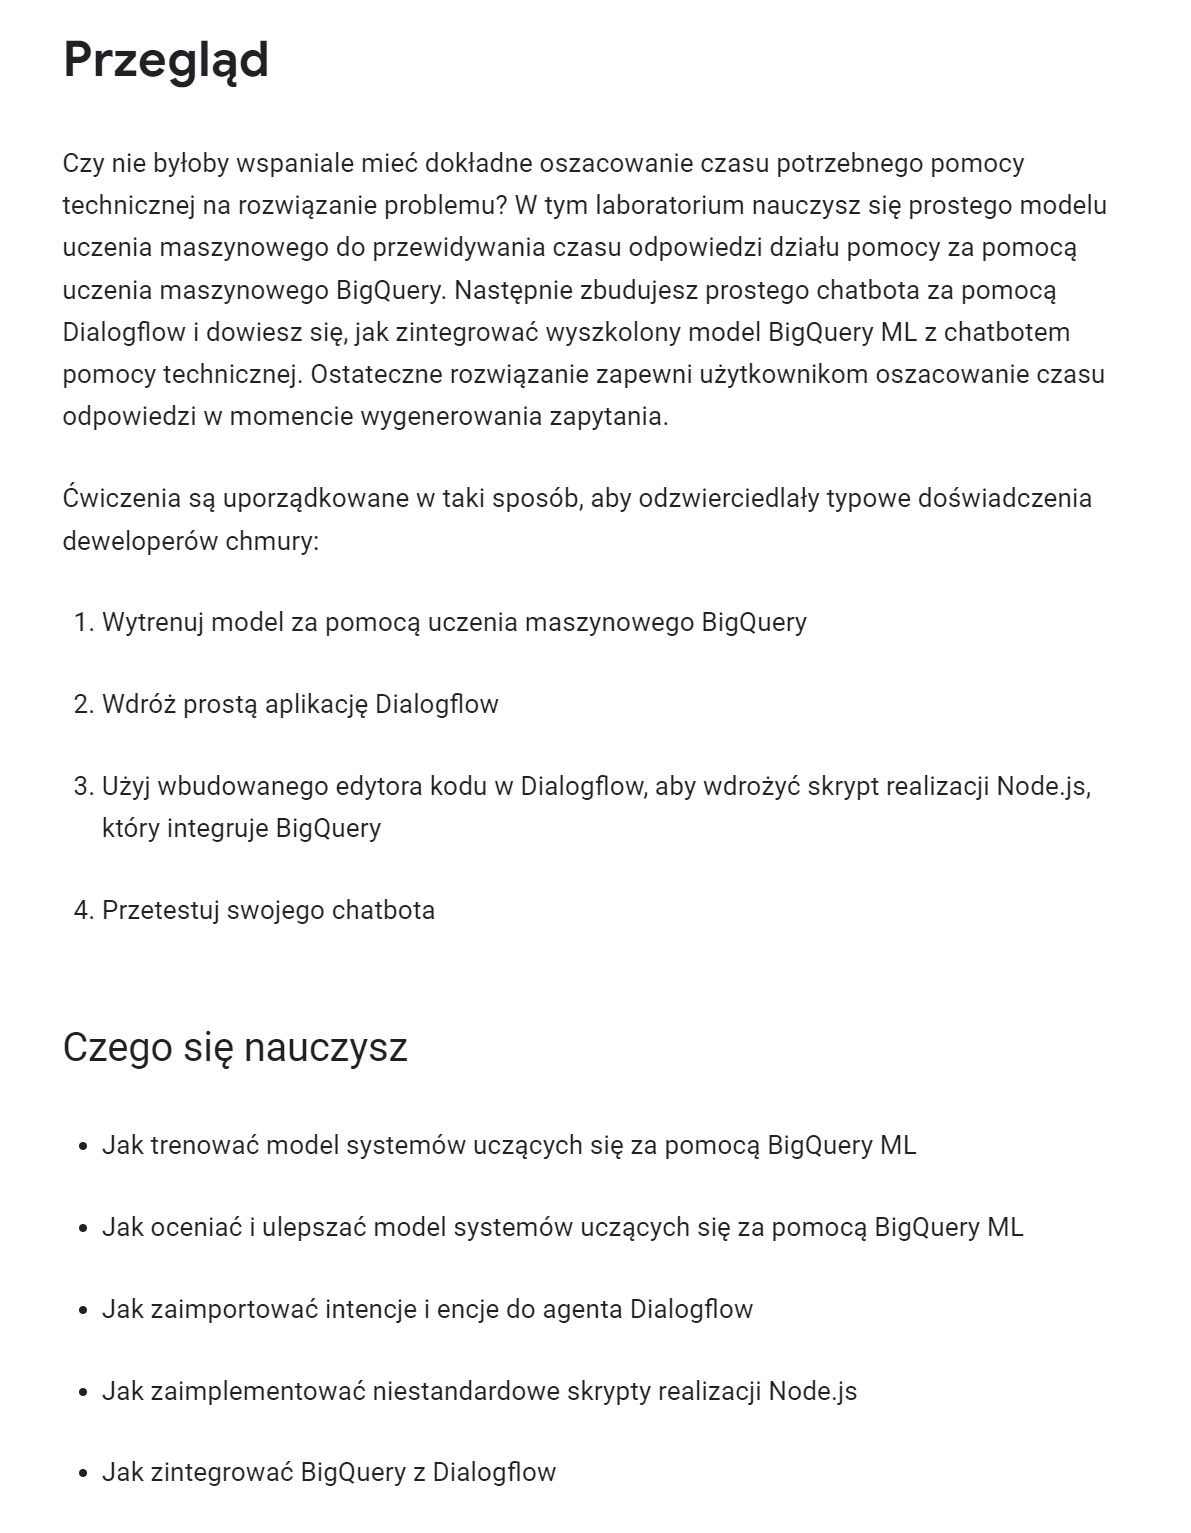

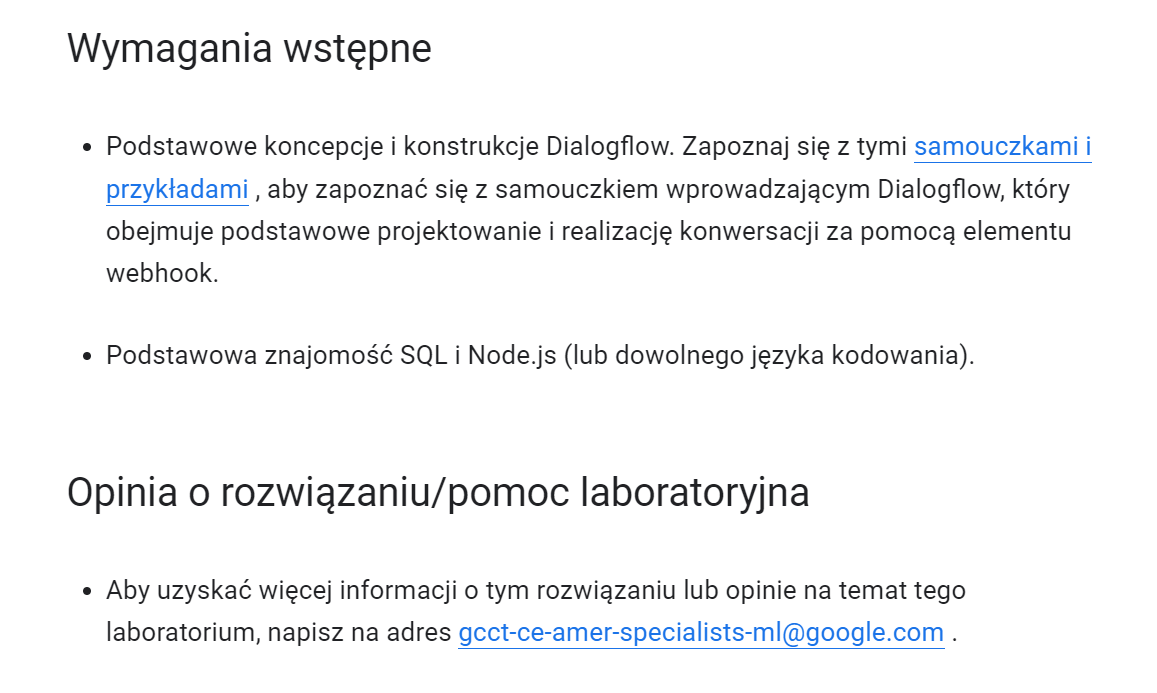

In [ ]:
# https://cloud.google.com/dialogflow/es/docs/tutorials

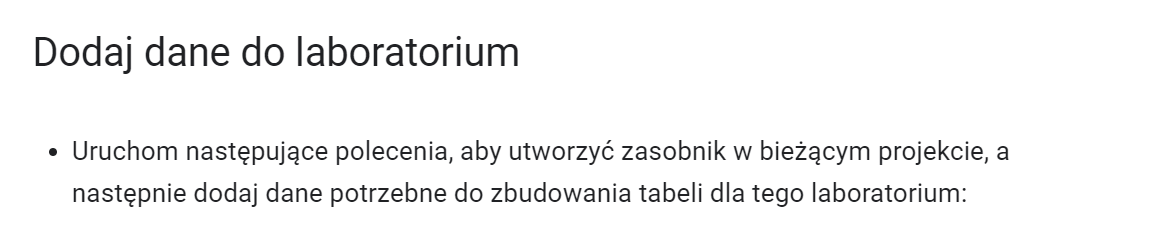

In [ ]:
# https://github.com/googlecodelabs/cloud-dialogflow-bqml

In [ ]:
PROJECT_ID=`gcloud config get-value project`
BUCKET=${PROJECT_ID}-bucket
gsutil mb gs://$BUCKET
gsutil cp -r gs://spls/gsp431/* gs://$BUCKET

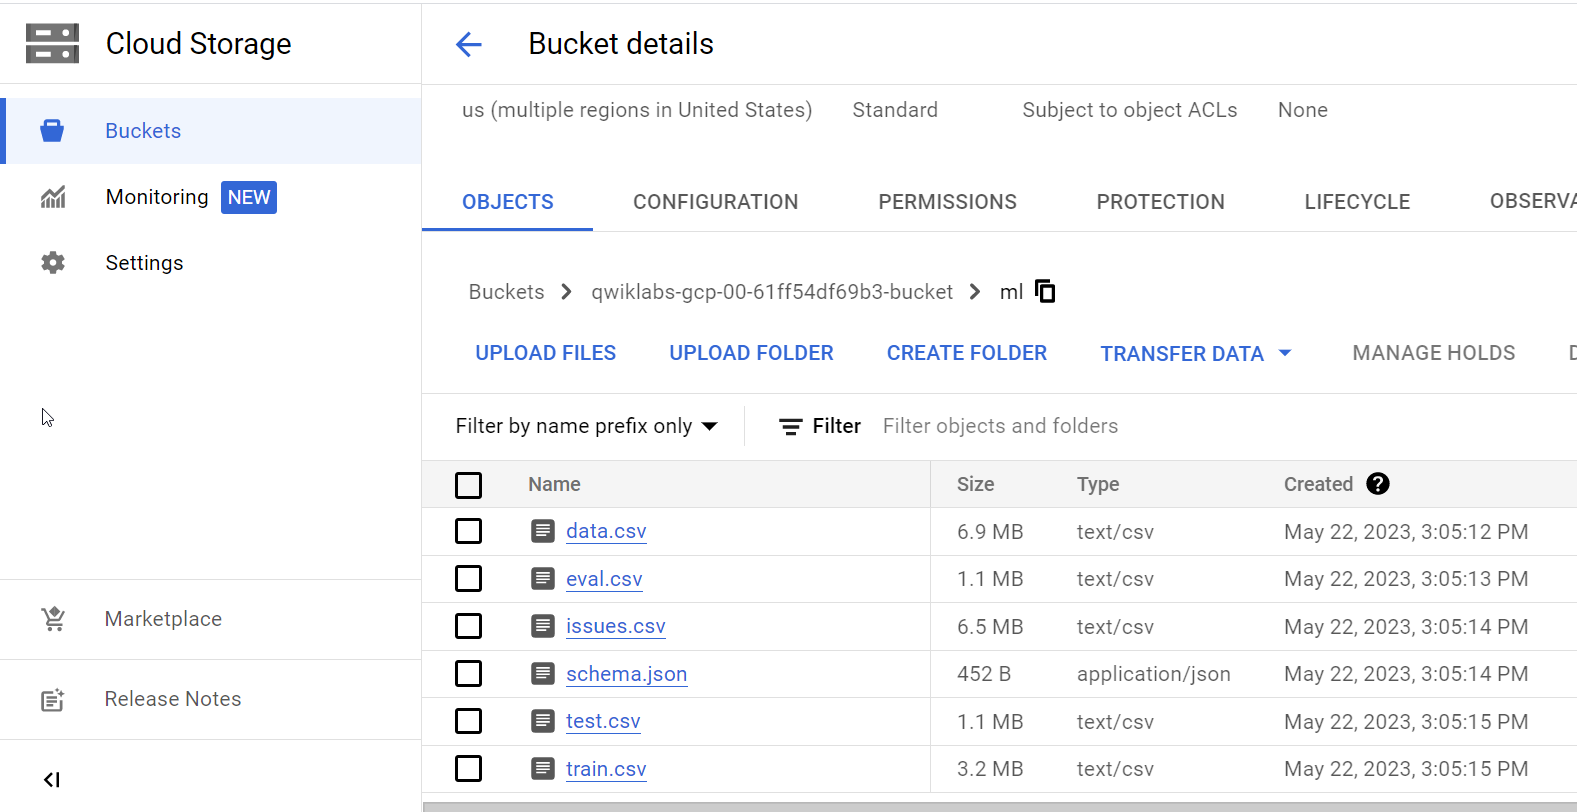

In [ ]:
# https://storage.cloud.google.com/qwiklabs-gcp-00-61ff54df69b3-bucket/ml/data.csv

# https://storage.cloud.google.com/qwiklabs-gcp-00-61ff54df69b3-bucket/ml/eval.csv

# https://storage.cloud.google.com/qwiklabs-gcp-00-61ff54df69b3-bucket/ml/issues.csv

# https://storage.cloud.google.com/qwiklabs-gcp-00-61ff54df69b3-bucket/ml/test.csv

# https://storage.cloud.google.com/qwiklabs-gcp-00-61ff54df69b3-bucket/ml/train.csv

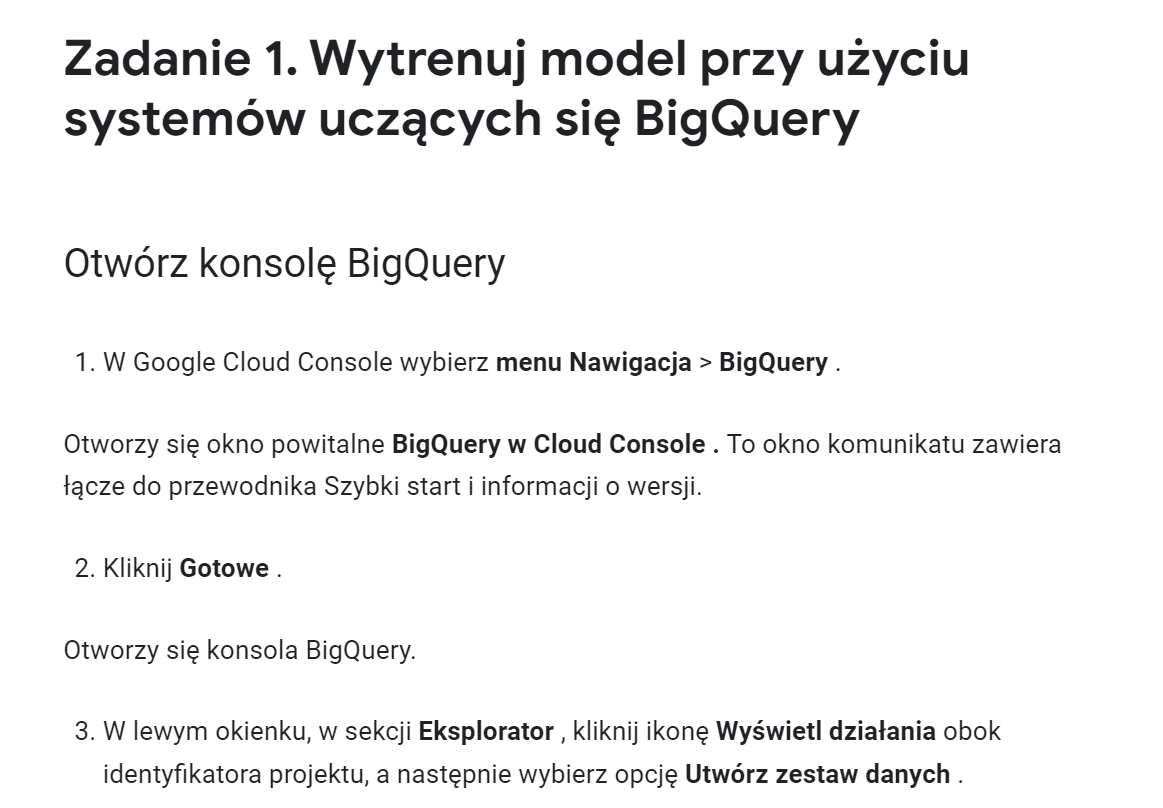

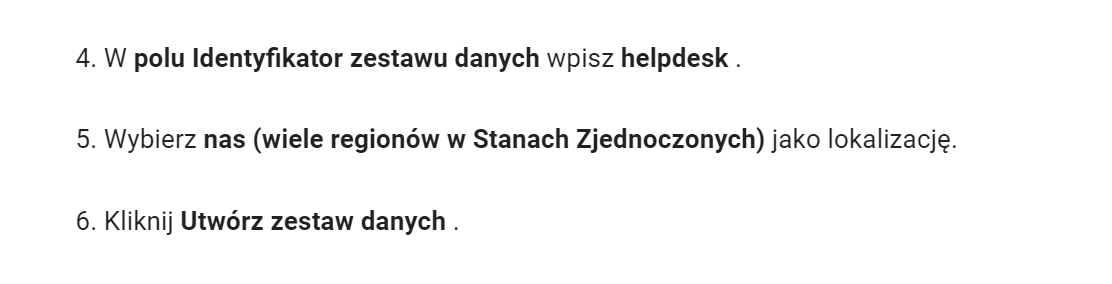

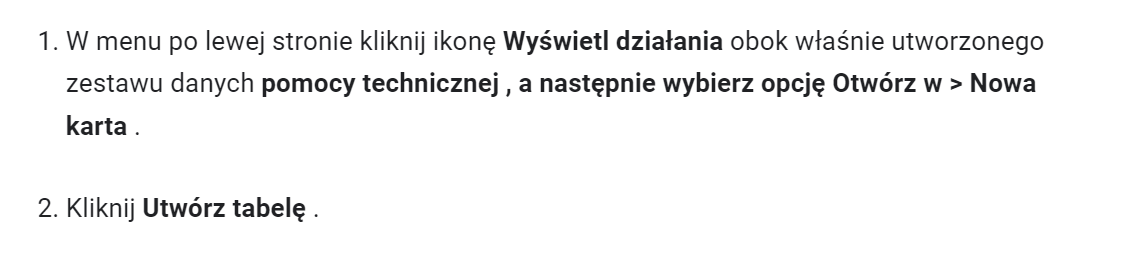

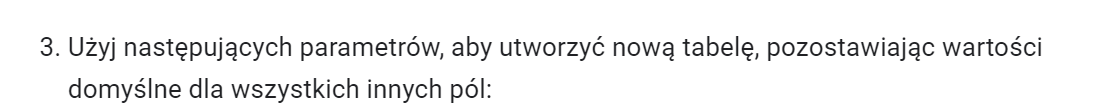

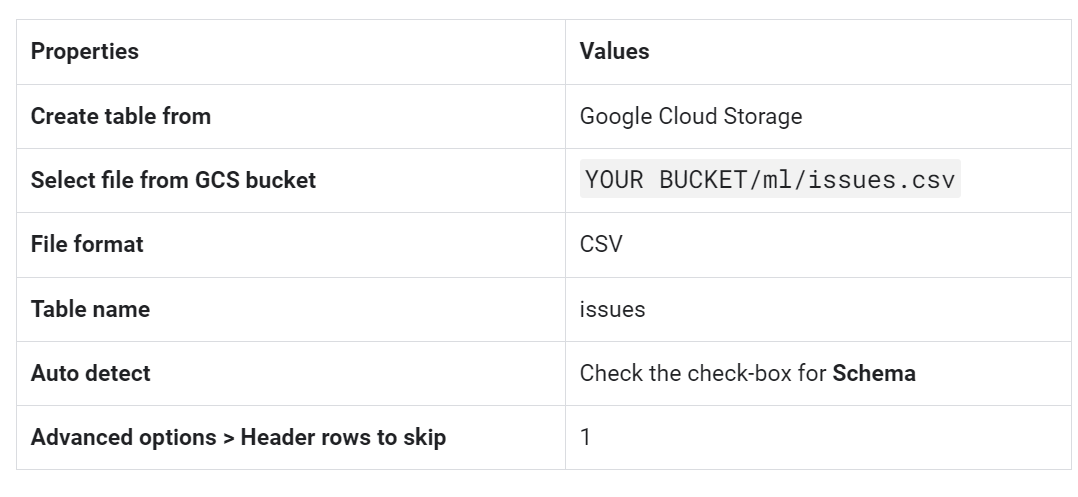

In [ ]:
# qwiklabs-gcp-00-61ff54df69b3-bucket/ml/issues.csv

# issues

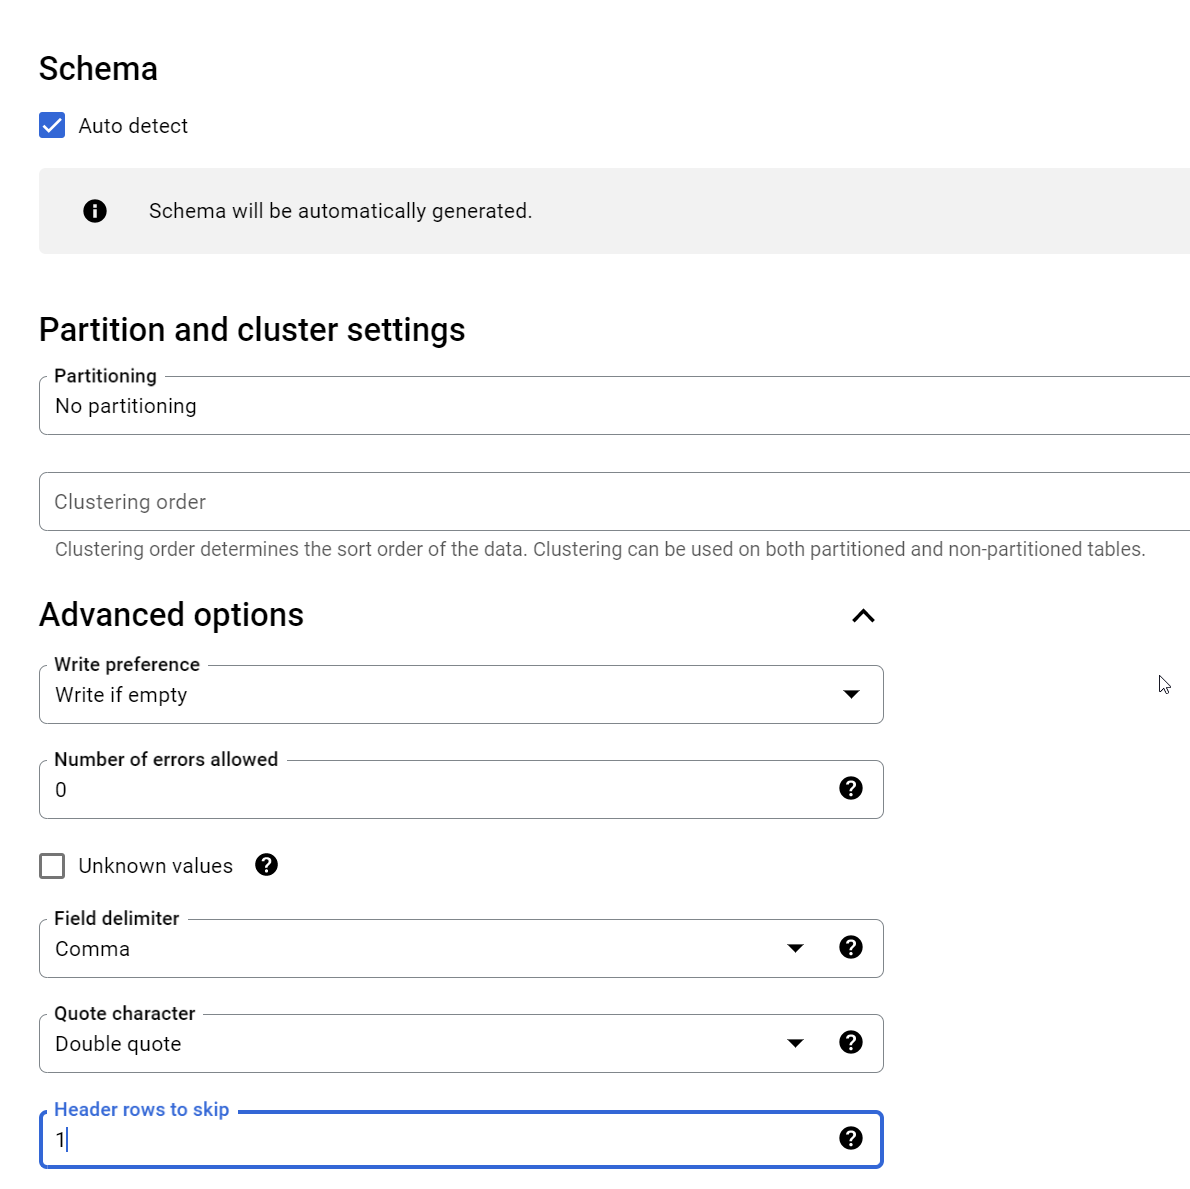

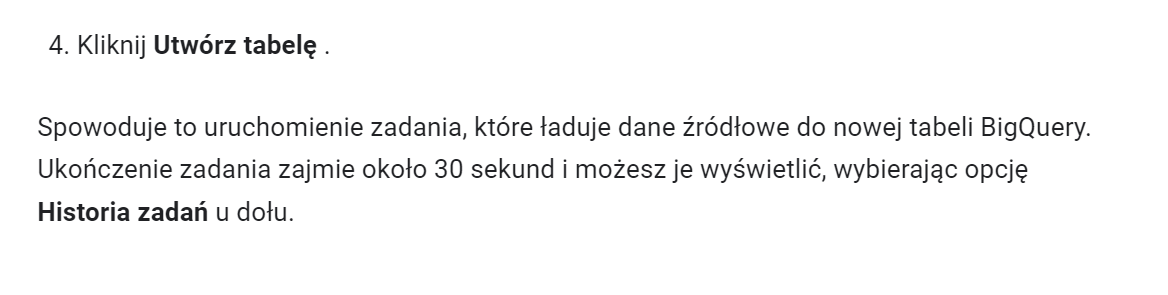

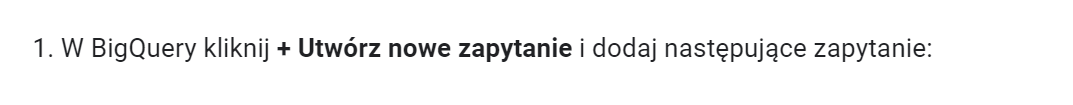

In [ ]:
%%bigquery

SELECT * FROM `helpdesk.issues` LIMIT 1000

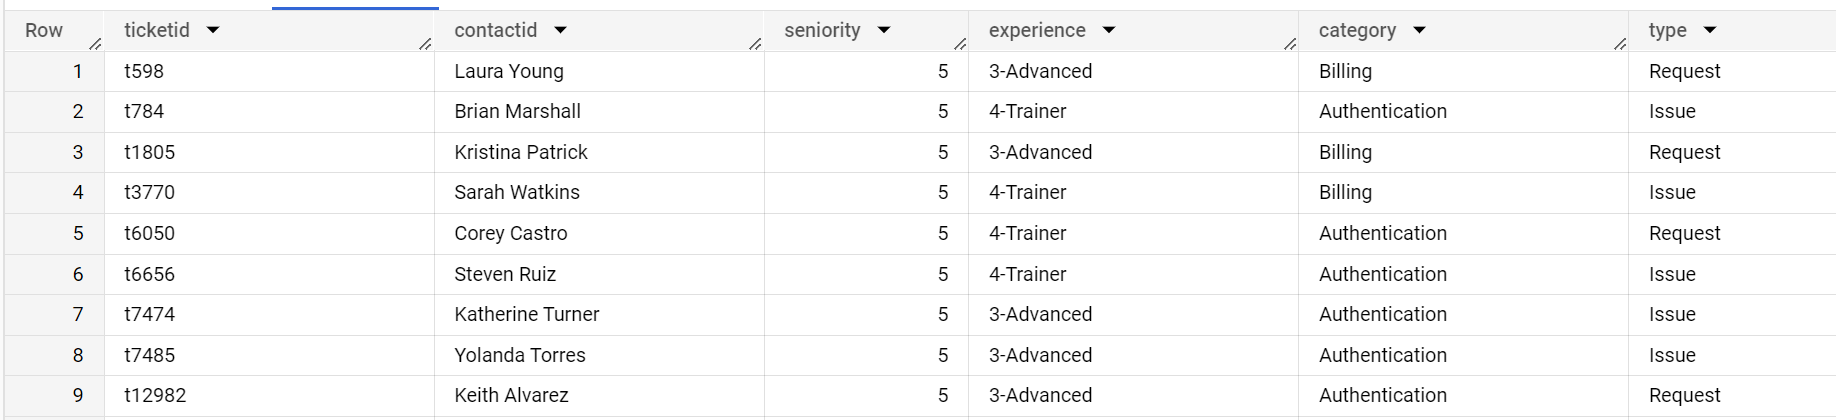

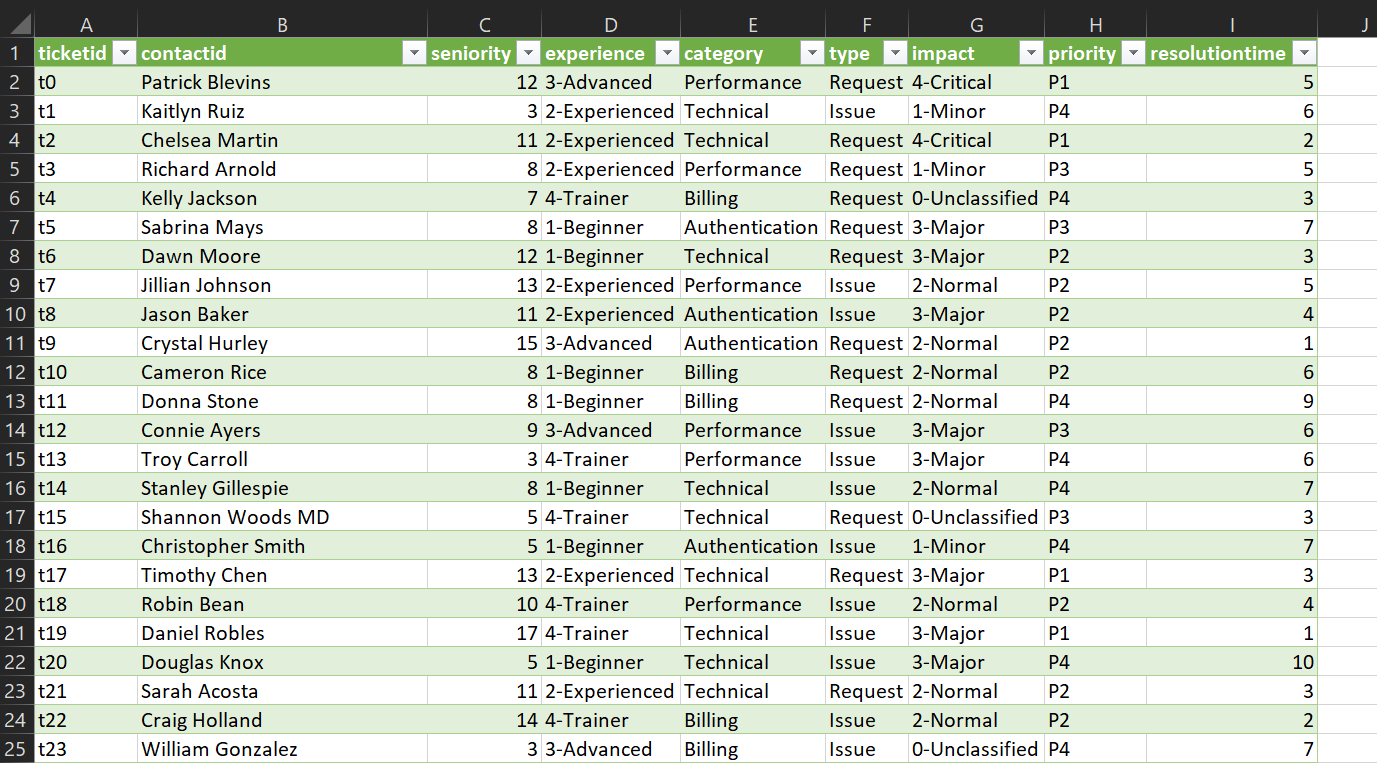

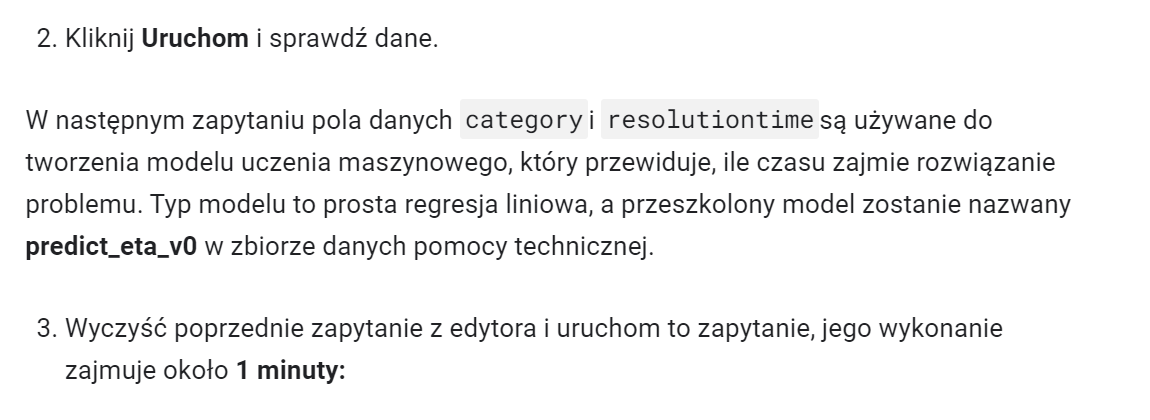

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL `helpdesk.predict_eta_v0`
OPTIONS(model_type='linear_reg') AS
SELECT
 category,
 resolutiontime as label
FROM
  `helpdesk.issues`

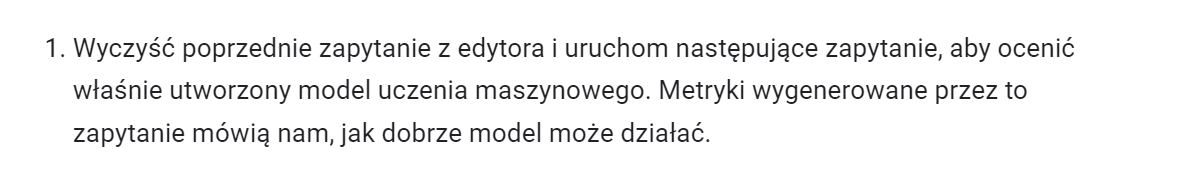

In [ ]:
%%bigquery

WITH eval_table AS (
SELECT
 category,
 resolutiontime as label
FROM
  helpdesk.issues
)

SELECT
  *
FROM
  ML.EVALUATE(MODEL helpdesk.predict_eta_v0, TABLE eval_table)

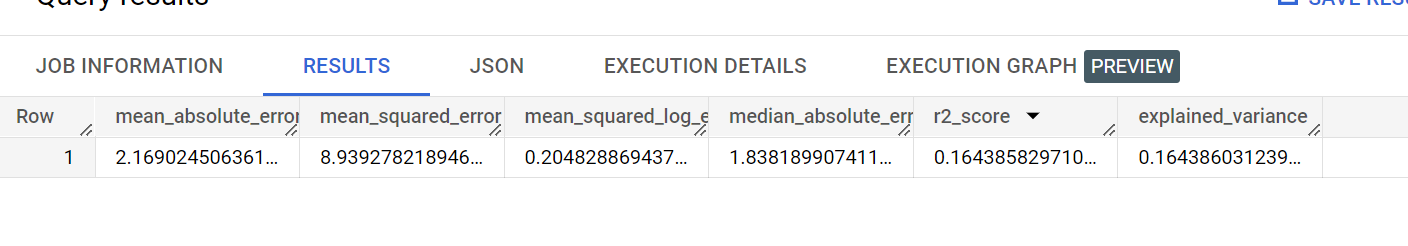

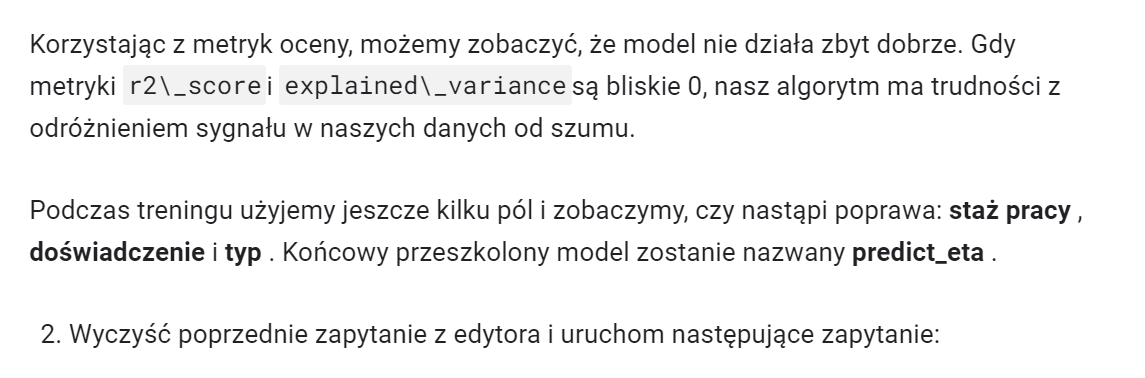

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL `helpdesk.predict_eta`
OPTIONS(model_type='linear_reg') AS
SELECT
 seniority,
 experience,
 category,
 type,
 resolutiontime as label
FROM
  `helpdesk.issues`

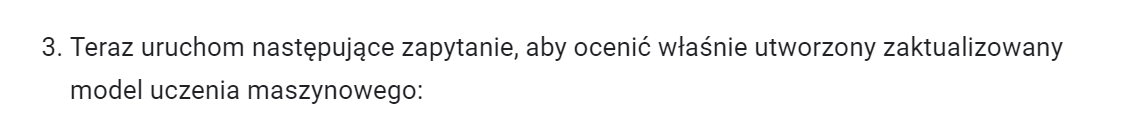

In [ ]:
%%bigquery

WITH eval_table AS (
SELECT
 seniority,
 experience,
 category,
 type,
 resolutiontime as label
FROM
  helpdesk.issues
)

SELECT
  *
FROM
  ML.EVALUATE(MODEL helpdesk.predict_eta, TABLE eval_table)

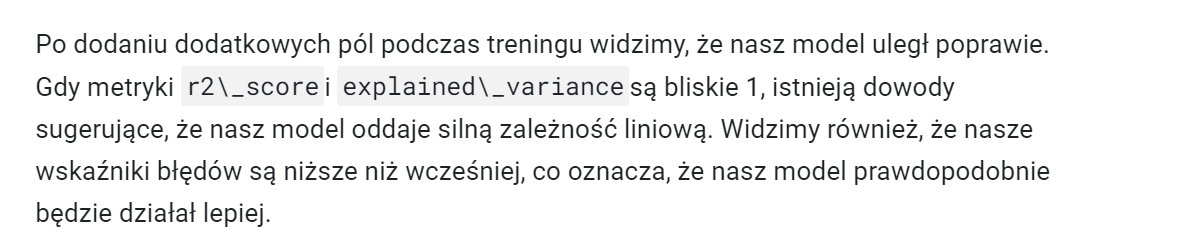

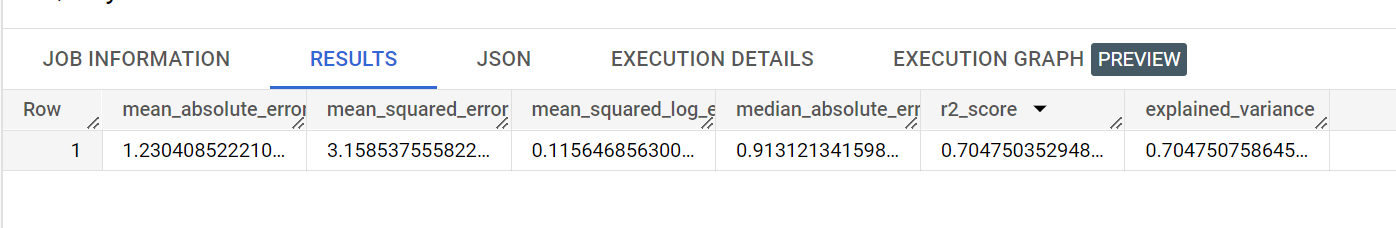

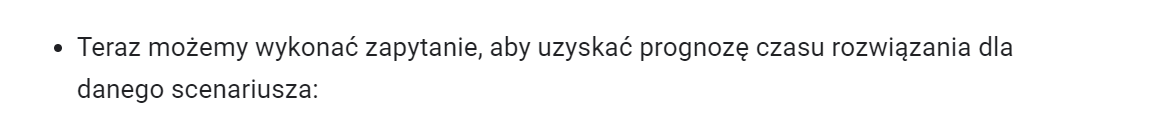

In [ ]:
%%bigquery

WITH pred_table AS (
SELECT
  5 as seniority,
  '3-Advanced' as experience,
  'Billing' as category,
  'Request' as type
)

SELECT
  *
FROM
  ML.PREDICT(MODEL `helpdesk.predict_eta`, TABLE pred_table)

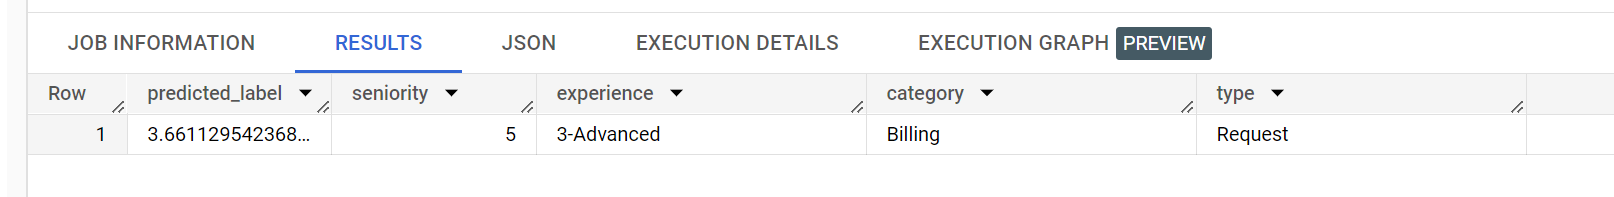

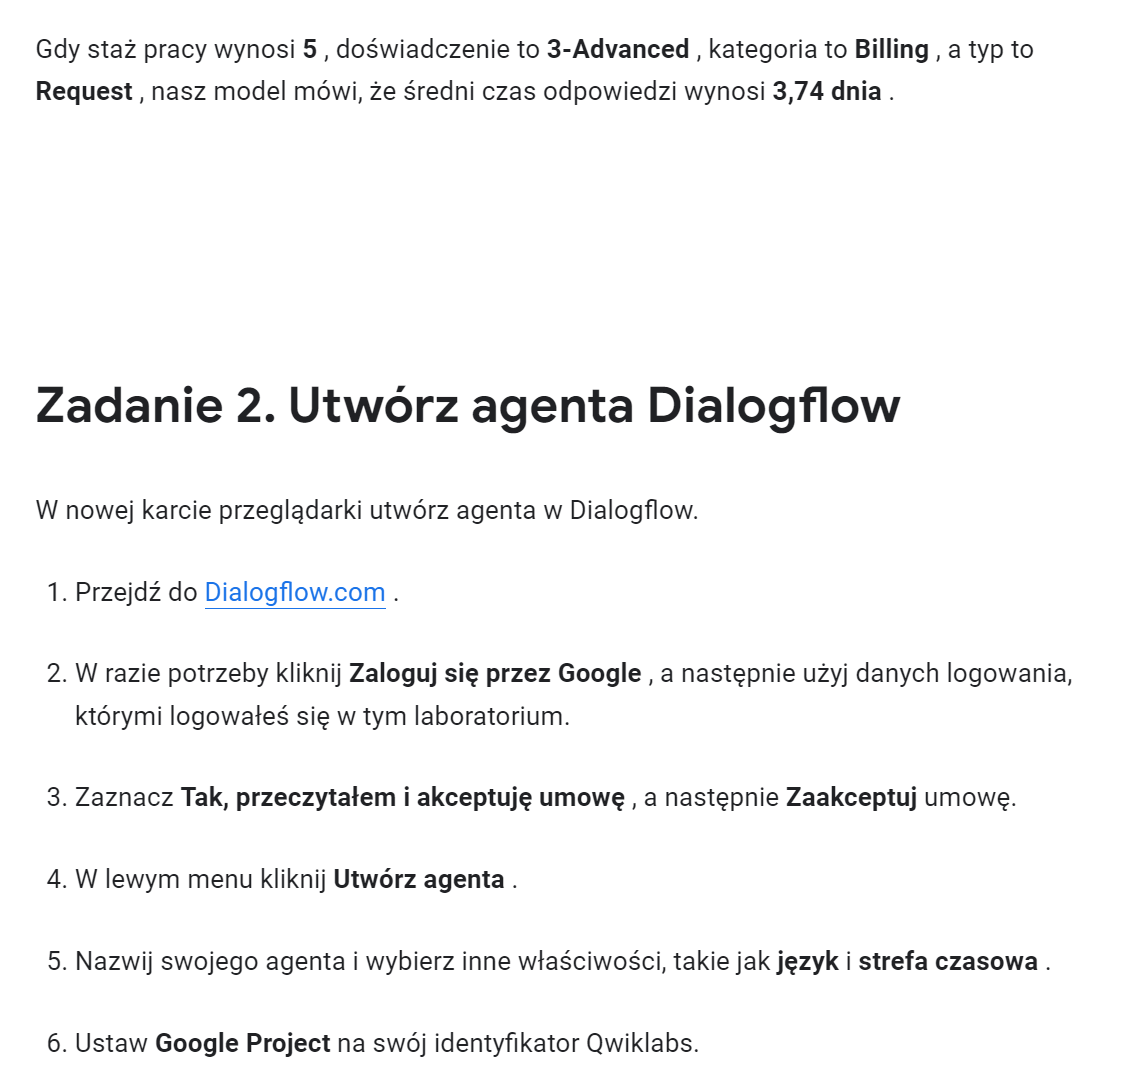

In [ ]:
# https://dialogflow.cloud.google.com/#/login

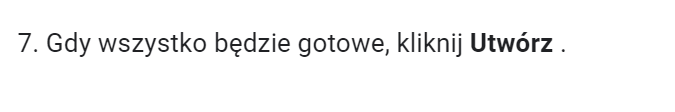

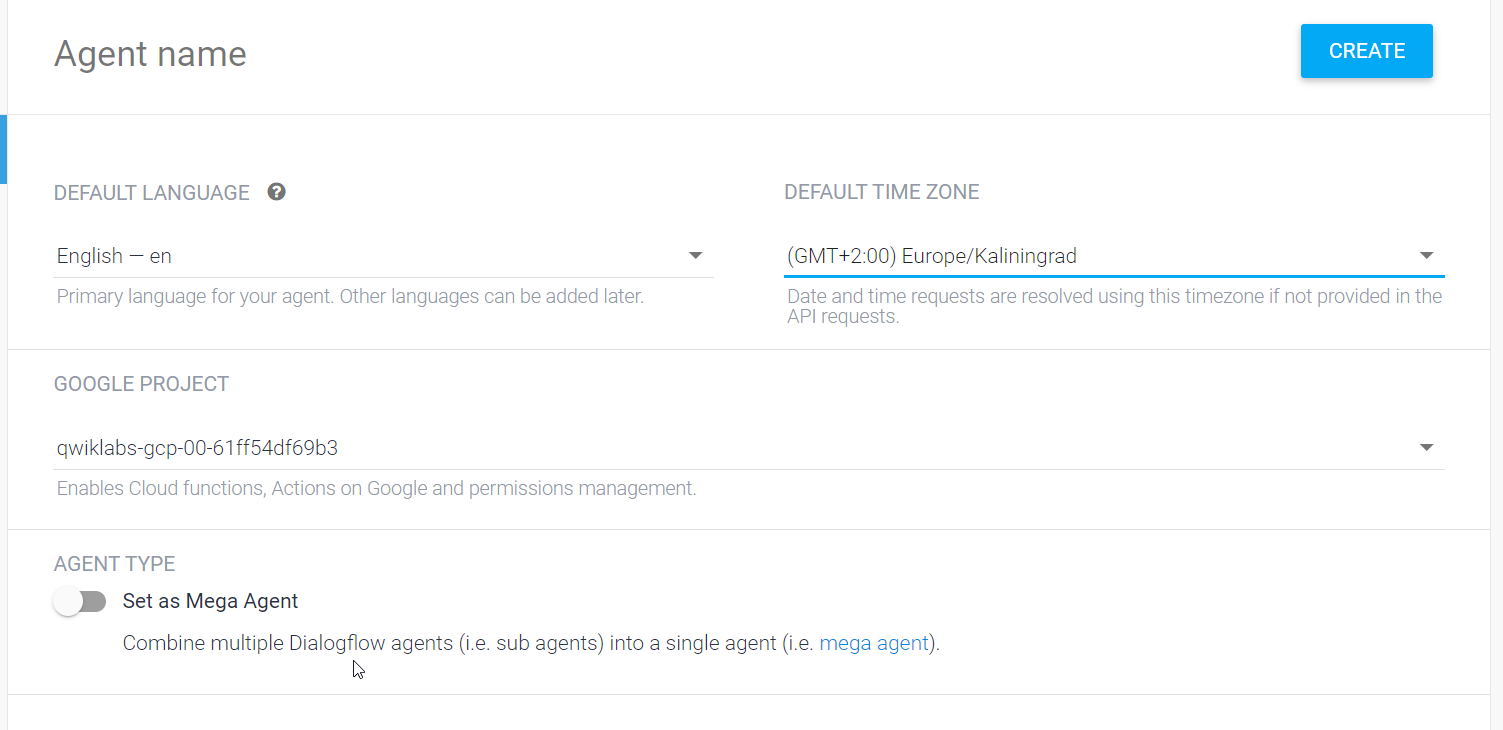

In [ ]:
# https://github.com/googlecodelabs/cloud-dialogflow-bqml

In [ ]:
# https://github.com/googlecodelabs/cloud-dialogflow-bqml/raw/master/ml-helpdesk-agent.zip

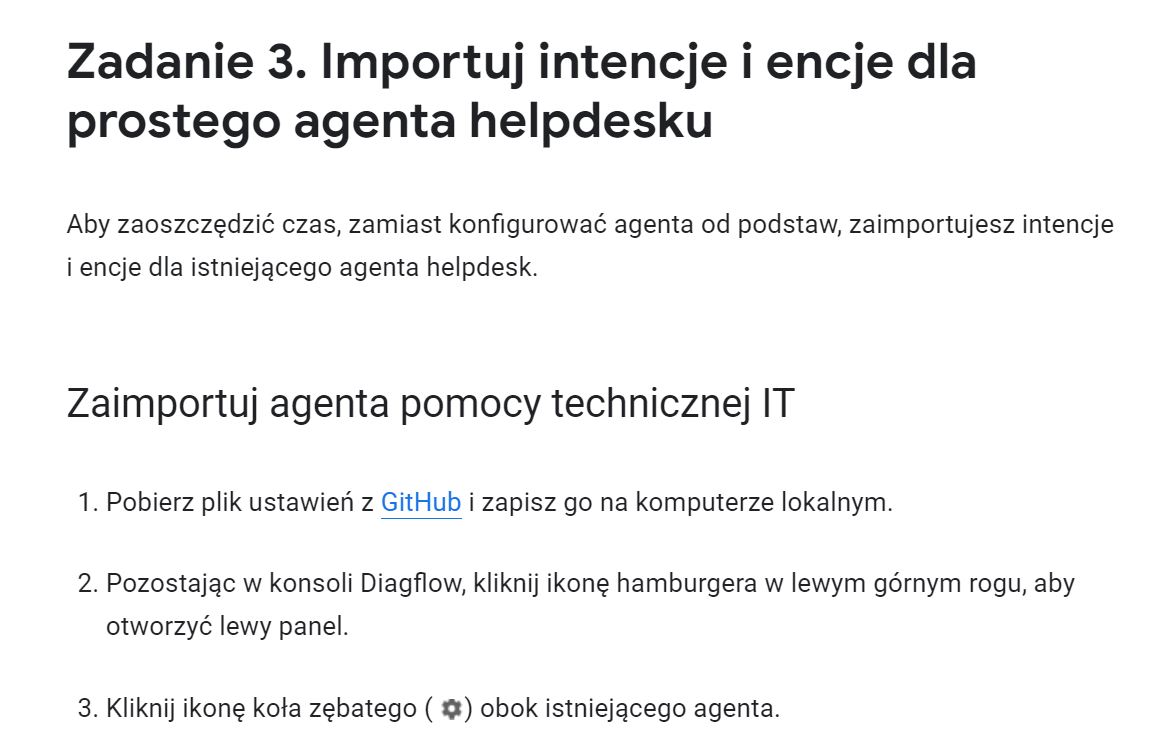

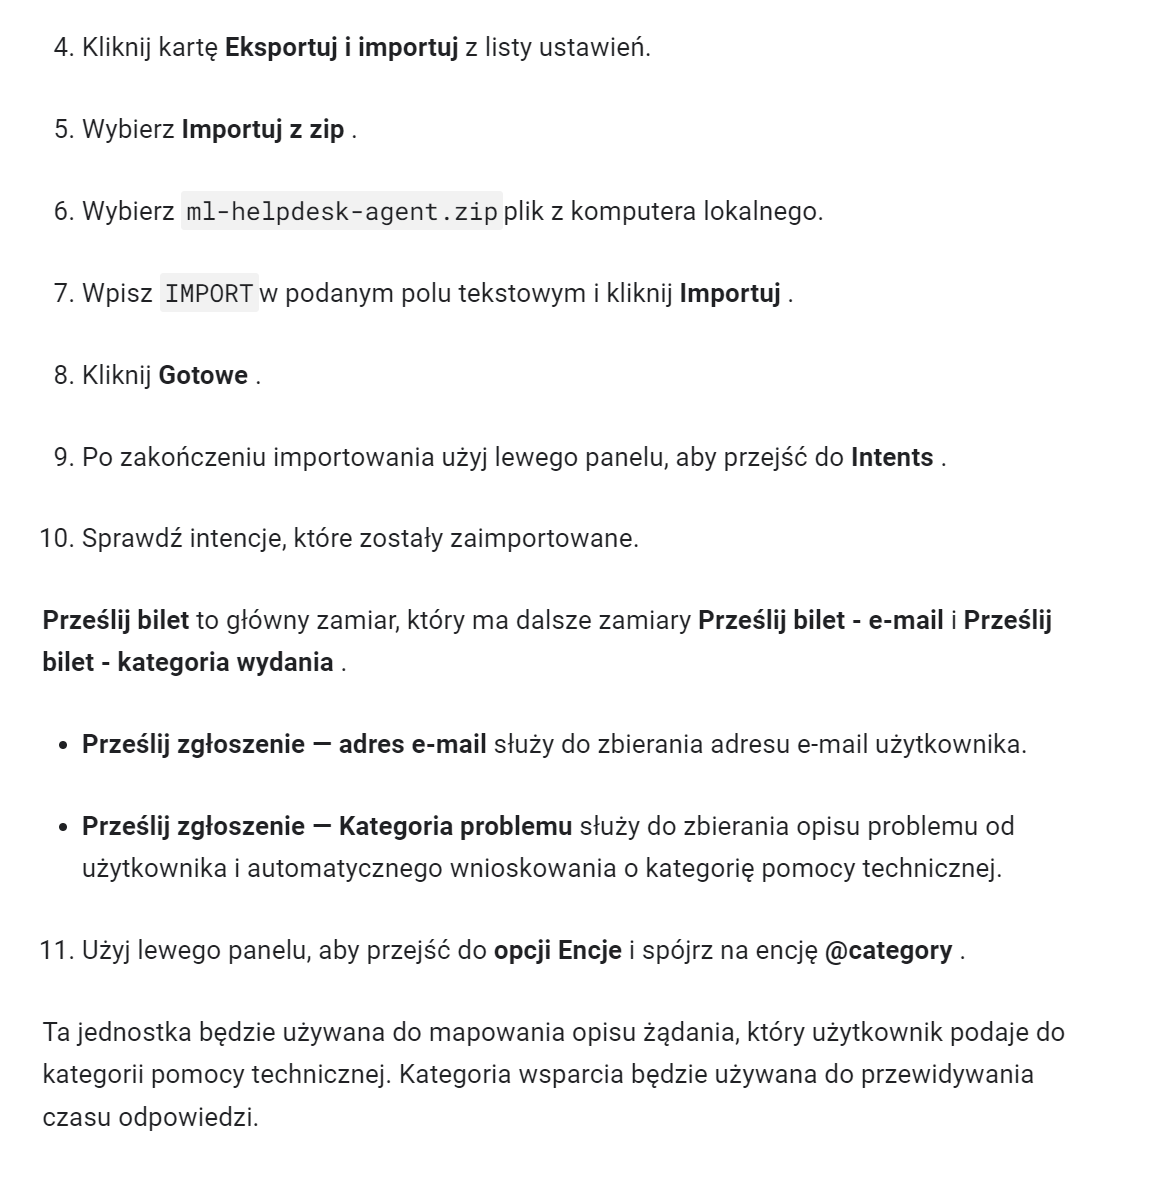

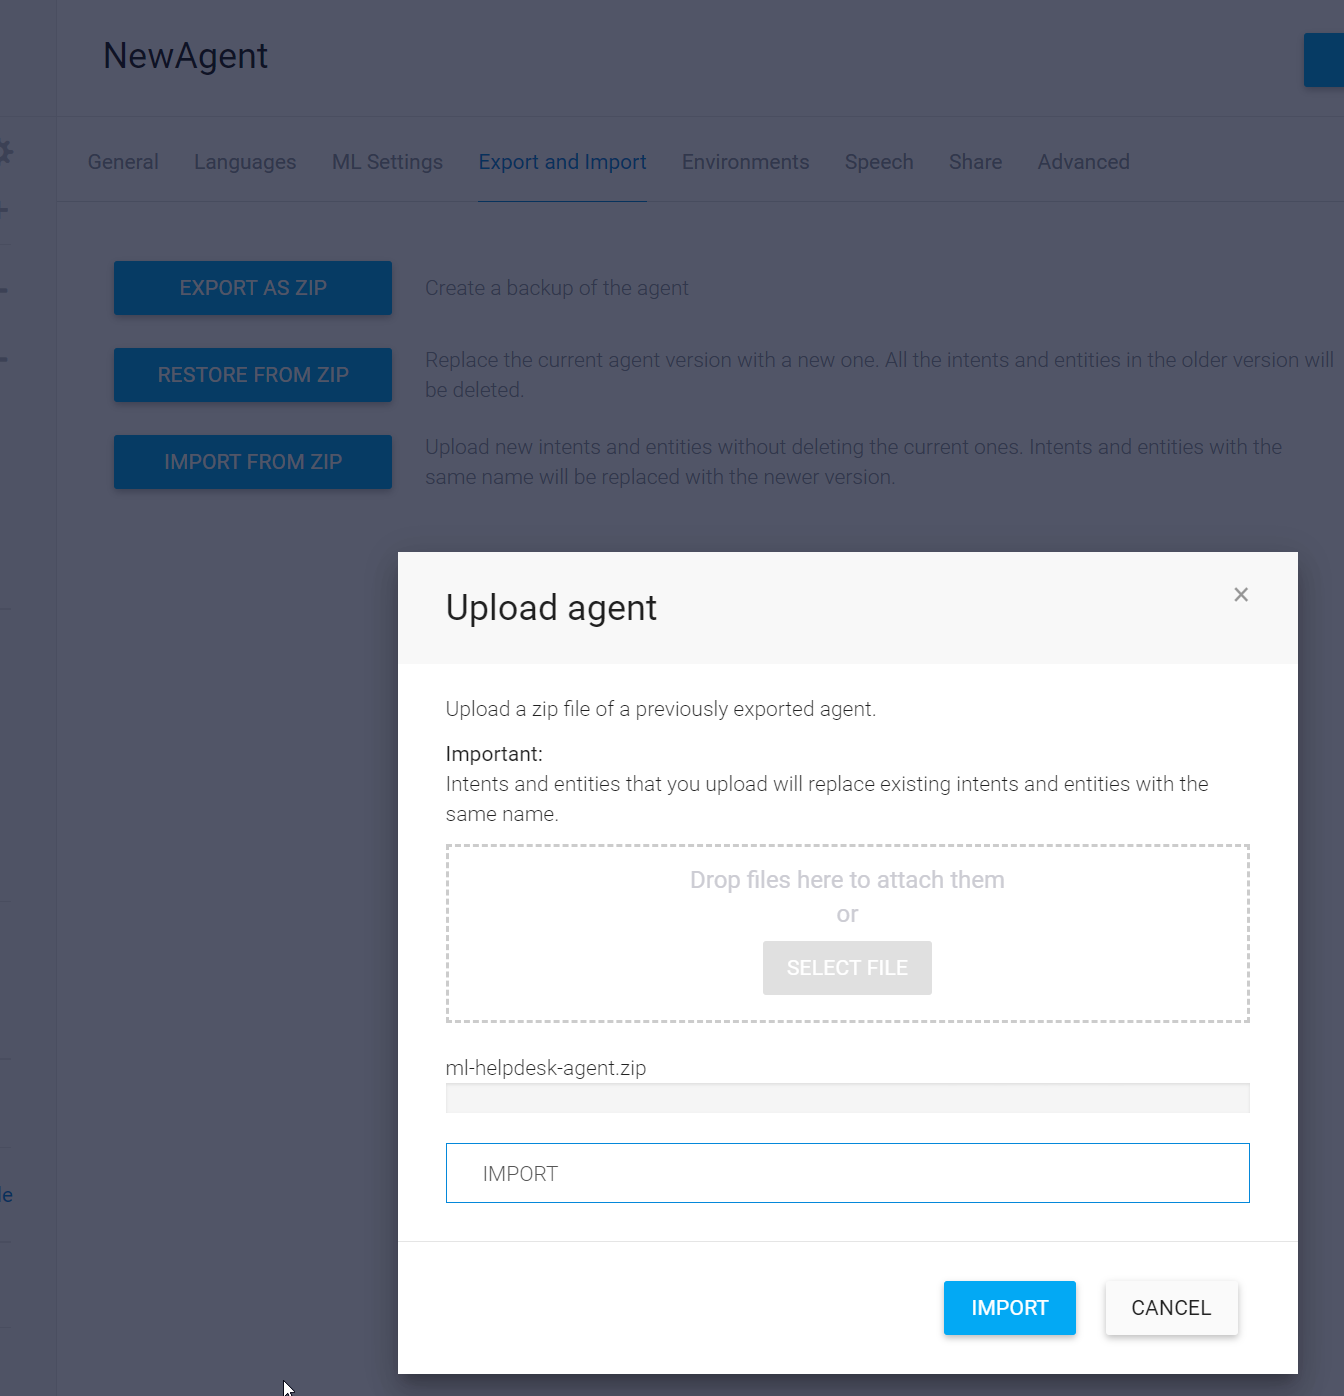

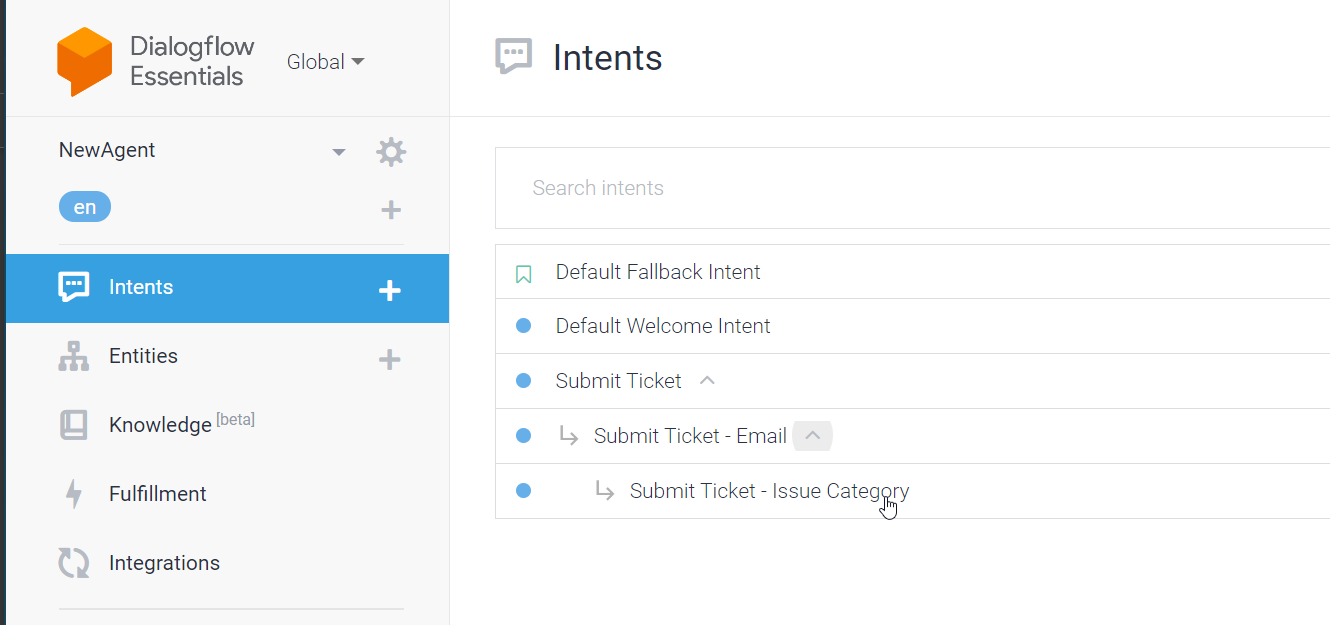

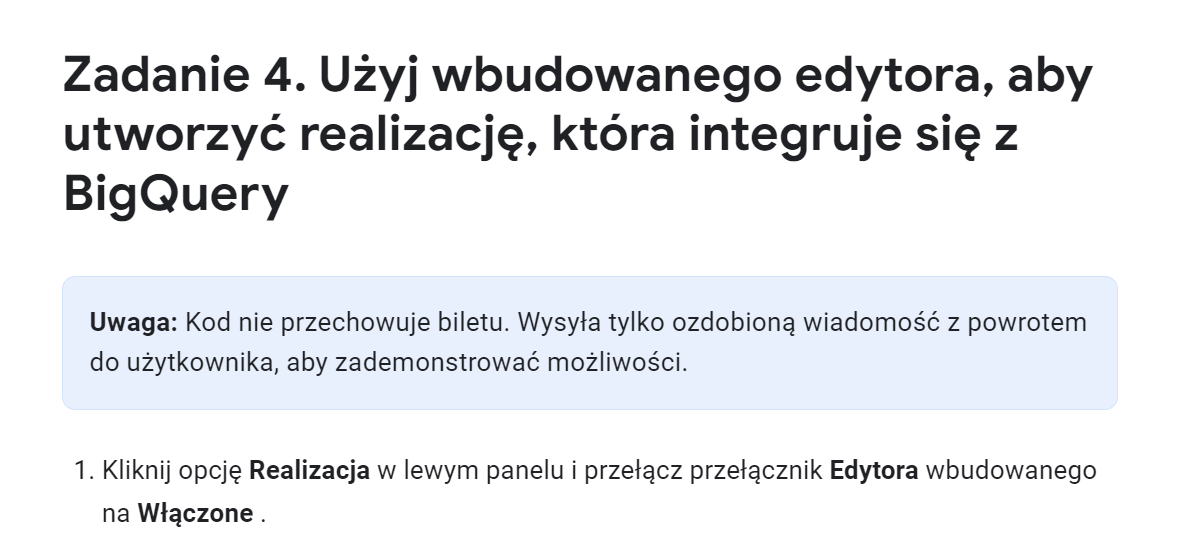

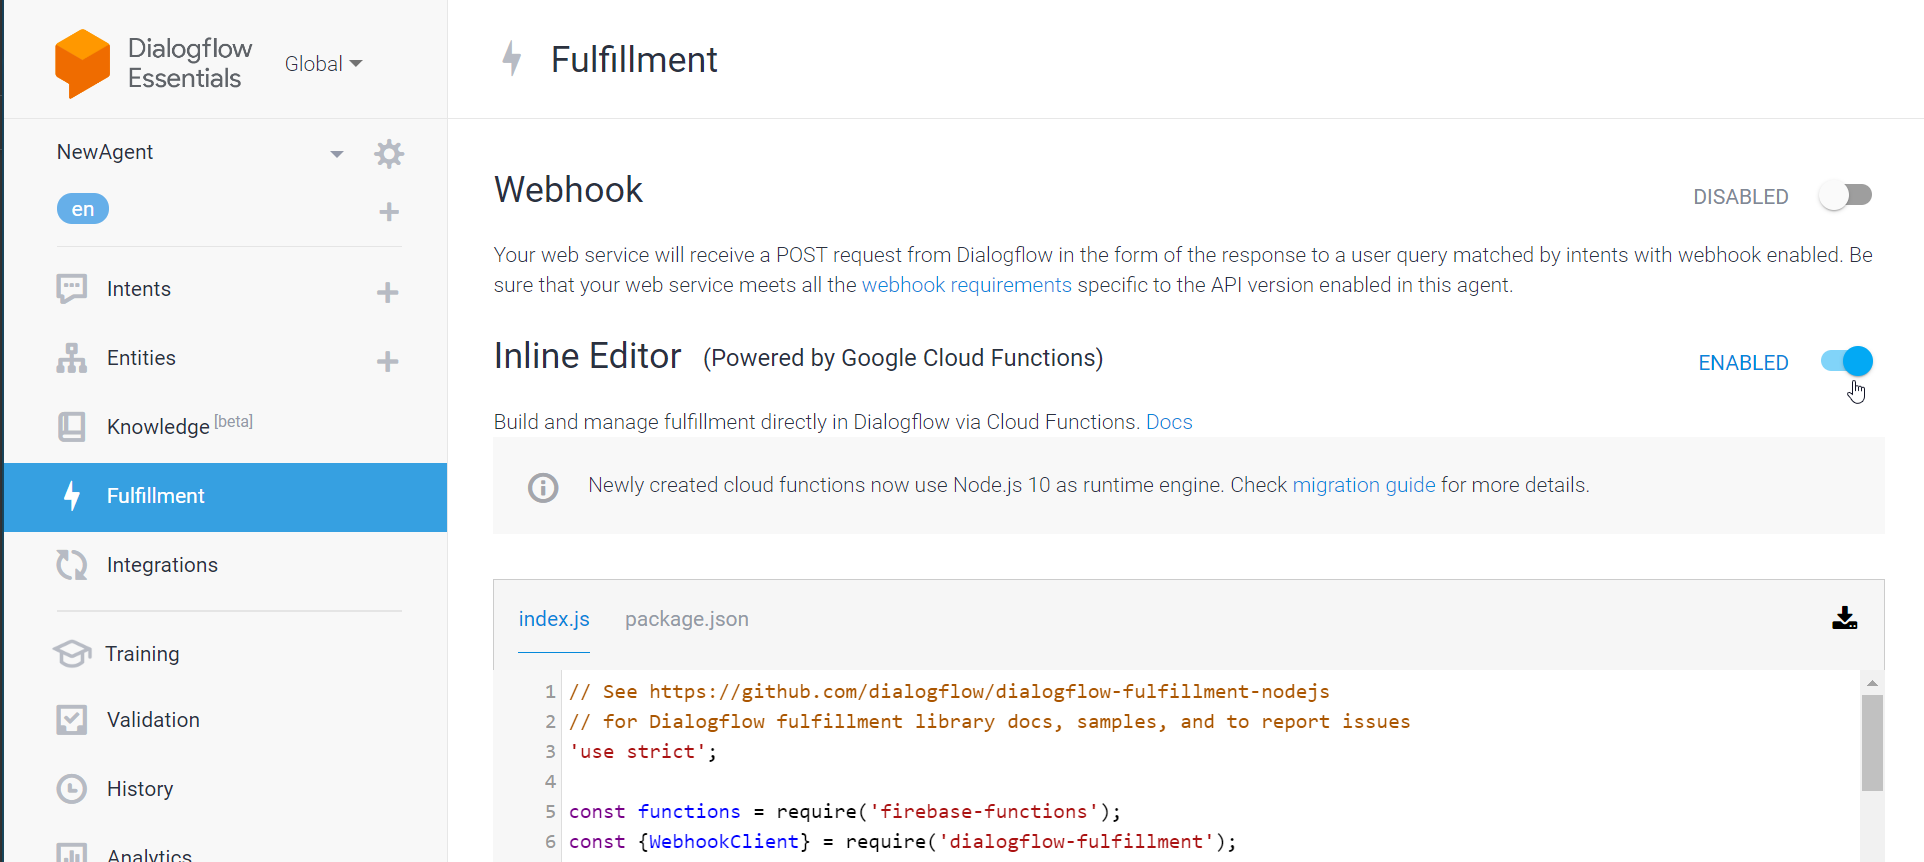

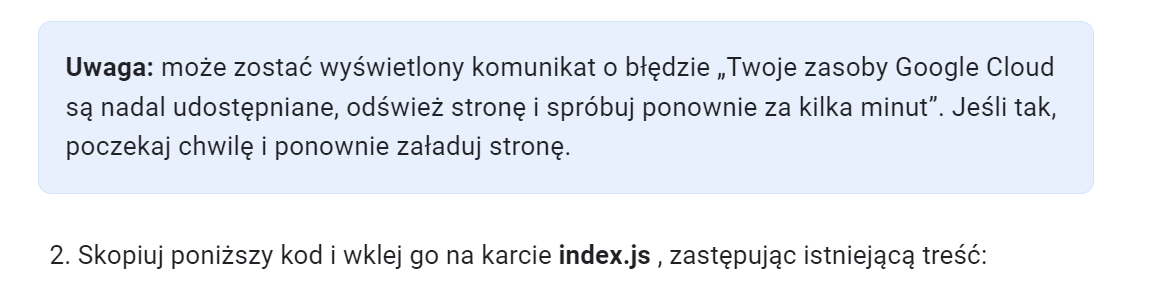

In [ ]:
%%javascript

/**
* Copyright 2020 Google Inc. All Rights Reserved.
*
* Licensed under the Apache License, Version 2.0 (the "License");
* you may not use this file except in compliance with the License.
* You may obtain a copy of the License at
*
*    http://www.apache.org/licenses/LICENSE-2.0
*
* Unless required by applicable law or agreed to in writing, software
* distributed under the License is distributed on an "AS IS" BASIS,
* WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
* See the License for the specific language governing permissions and
* limitations under the License.
*/
"use strict";
const functions = require("firebase-functions");
const { WebhookClient } = require("dialogflow-fulfillment");
const { Card, Payload } = require("dialogflow-fulfillment");
const { BigQuery } = require("@google-cloud/bigquery");
const bigquery = new BigQuery({
    projectId: "qwiklabs-gcp-00-61ff54df69b3" // ** CHANGE THIS **
});
process.env.DEBUG = "dialogflow:debug";
function welcome(agent) {
    agent.add(`Welcome to my agent!`);
}
function fallback(agent) {
    agent.add(`I didn't understand`);
    agent.add(`I'm sorry, can you try again?`);
}
async function etaPredictionFunction(agent) {
    const issueCategory = agent.getContext('submitticket-email-followup').parameters.category;
    const sqlQuery = `WITH pred_table AS (SELECT 5 as seniority, "3-Advanced" as experience,
    @category as category, "Request" as type)
    SELECT cast(predicted_label as INT64) as predicted_label
    FROM ML.PREDICT(MODEL helpdesk.predict_eta,  TABLE pred_table)`;
    const options = {
        query: sqlQuery,
        location: "US",
        params: {
            category: issueCategory
        }
    };
    const [rows] = await bigquery.query(options);
    return rows;
}
async function ticketCollection(agent) {
    const email = agent.getContext('submitticket-email-followup').parameters.email;
    const issueCategory = agent.getContext('submitticket-email-followup').parameters.category;
    let etaPrediction = await etaPredictionFunction(agent);
    agent.setContext({
        name: "submitticket-collectname-followup",
        lifespan: 2
    });
    agent.add(`Your ticket has been created. Someone will contact you shortly at ${email}.
    The estimated response time is ${etaPrediction[0].predicted_label} days.`);
}
exports.dialogflowFirebaseFulfillment = functions.https.onRequest((request, response) => {
    const agent = new WebhookClient({ request, response });
    console.log('Dialogflow Request headers: ' + JSON.stringify(request.headers));
    console.log('Dialogflow Request body: ' + JSON.stringify(request.body));
    let intentMap = new Map();
    intentMap.set("Default Welcome Intent", welcome);
    intentMap.set("Default Fallback Intent", fallback);
    intentMap.set("Submit Ticket - Issue Category", ticketCollection);
    agent.handleRequest(intentMap);
});

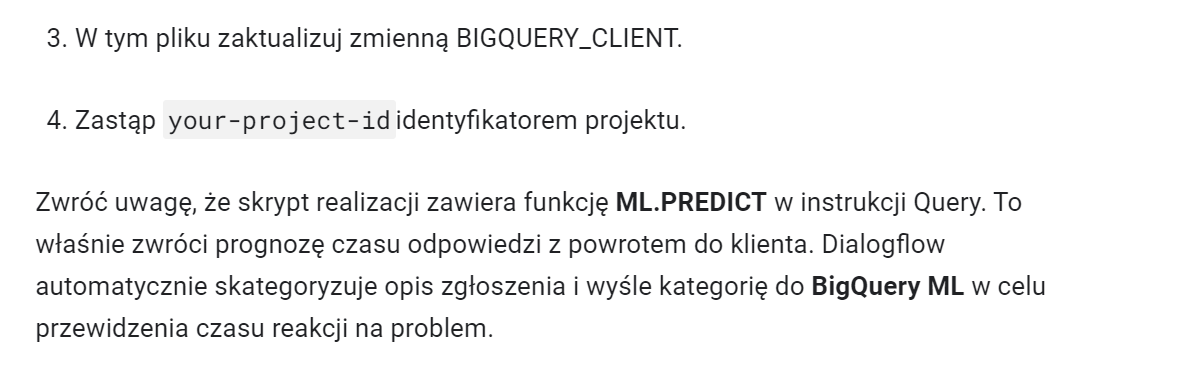

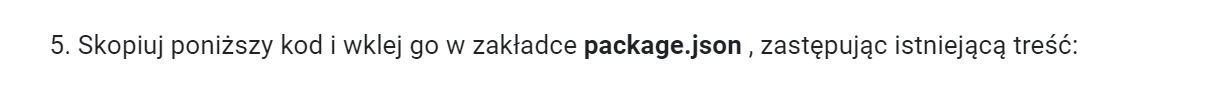

In [ ]:
{
  "name": "dialogflowFirebaseFulfillment",
  "description": "This is the default fulfillment for a Dialogflow agents using Cloud Functions for Firebase",
  "version": "0.0.1",
  "private": true,
  "license": "Apache Version 2.0",
  "author": "Google Inc.",
  "engines": {
    "node": "10"
  },
  "scripts": {
    "start": "firebase serve --only functions:dialogflowFirebaseFulfillment",
    "deploy": "firebase deploy --only functions:dialogflowFirebaseFulfillment"
  },
  "dependencies": {
    "actions-on-google": "^2.2.0",
    "firebase-admin": "^5.13.1",
    "firebase-functions": "^2.0.2",
    "dialogflow": "^0.6.0",
    "dialogflow-fulfillment": "^0.5.0",
    "@google-cloud/bigquery": "^4.7.0"
  }
}

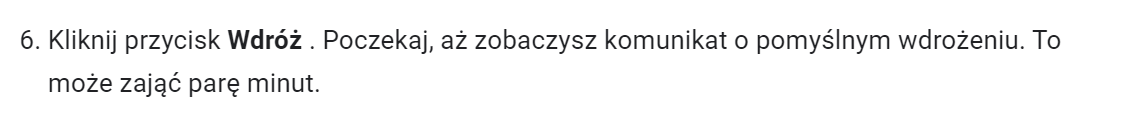

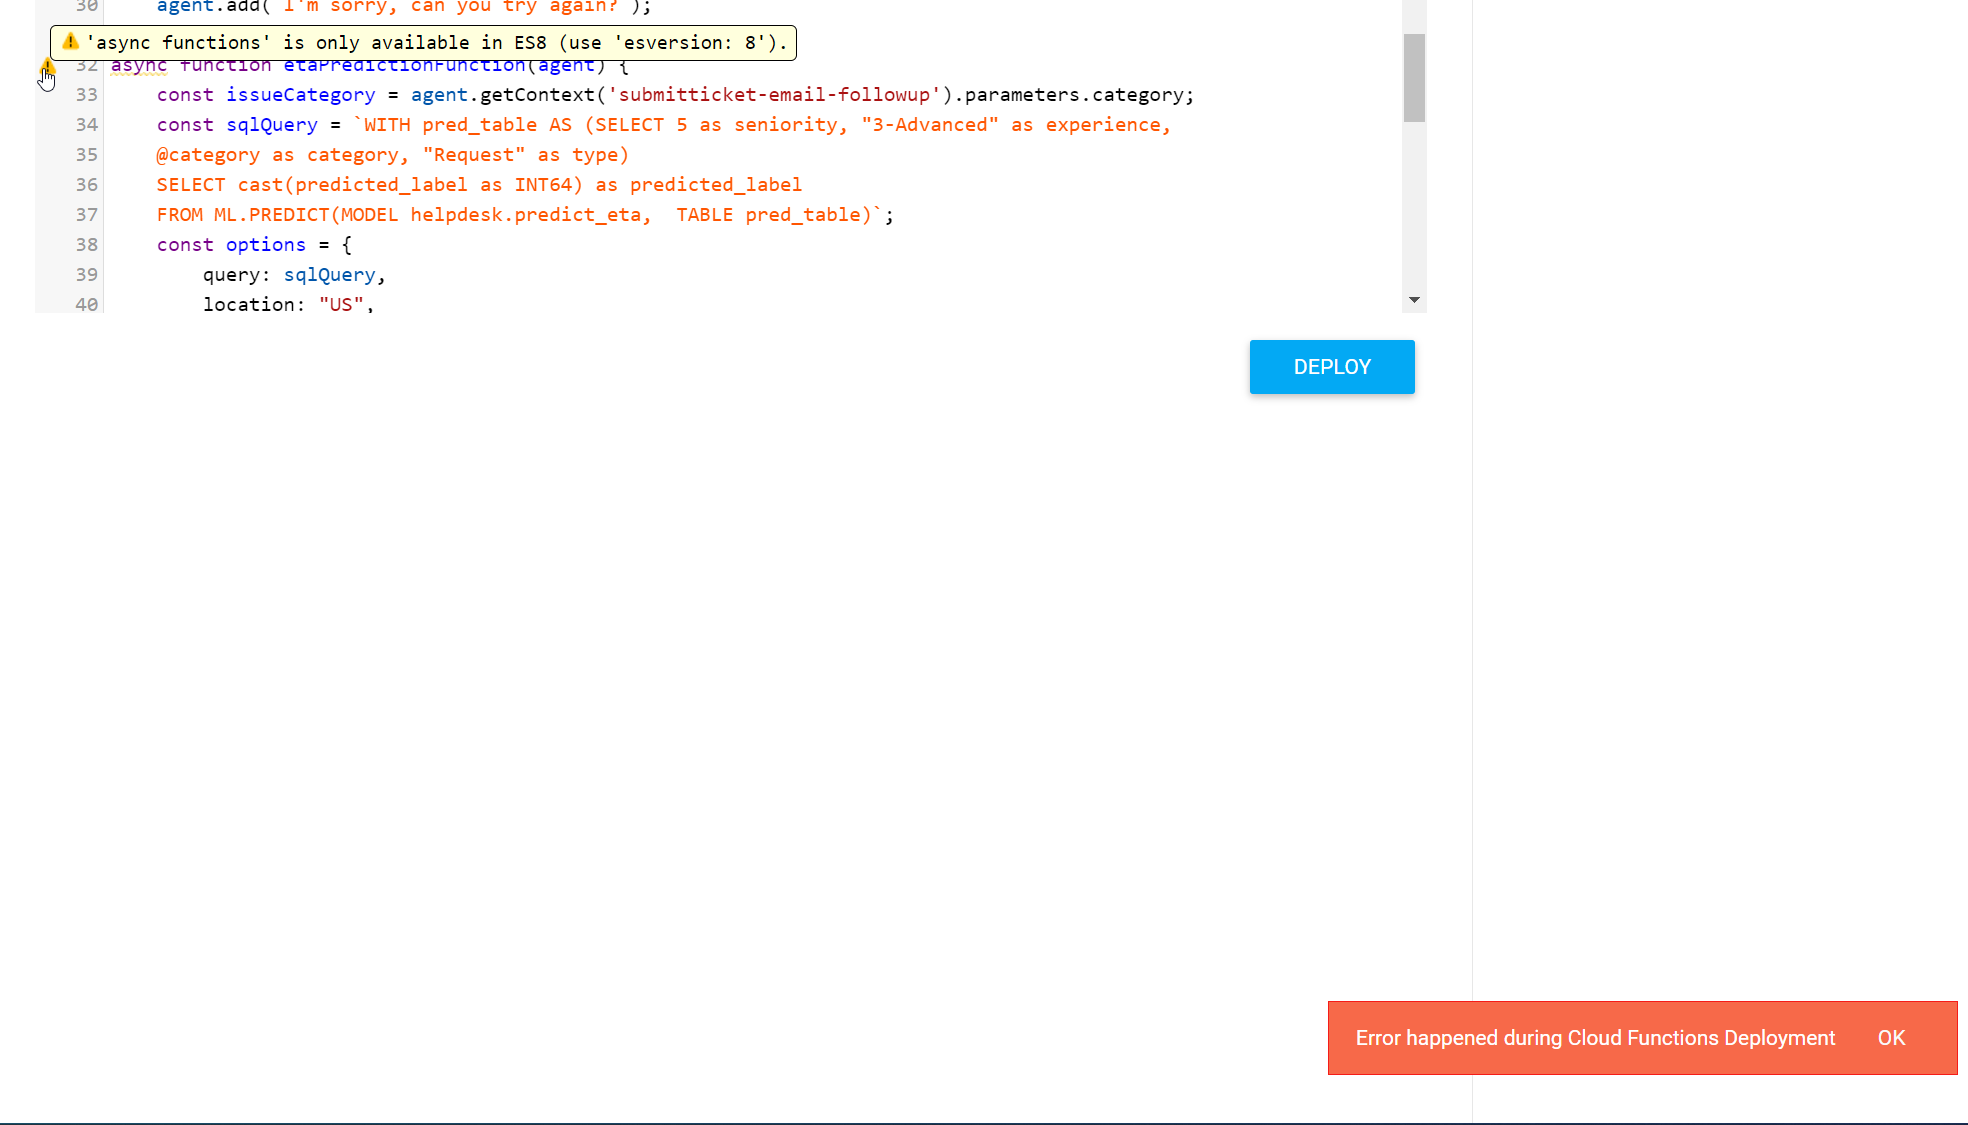

Function is deployed but not in ACTIVE state. Wait for few seconds.

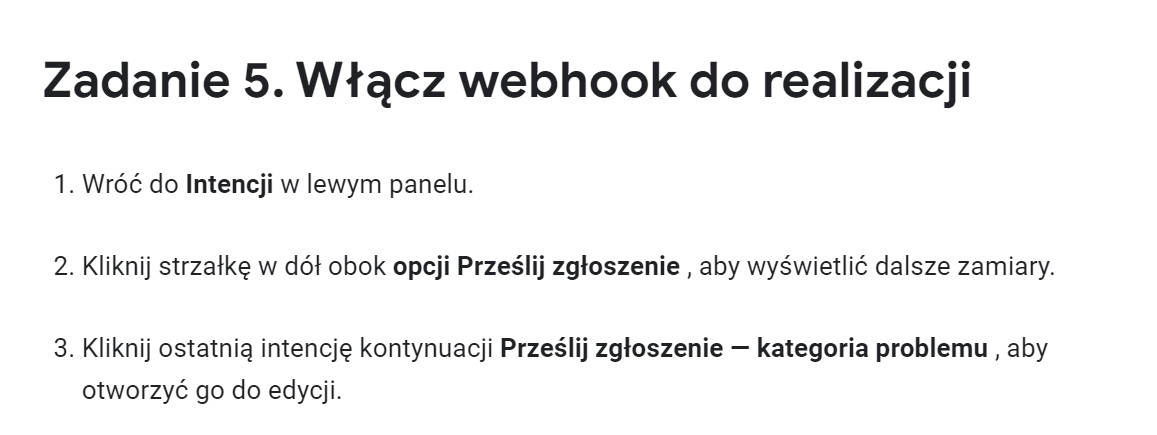

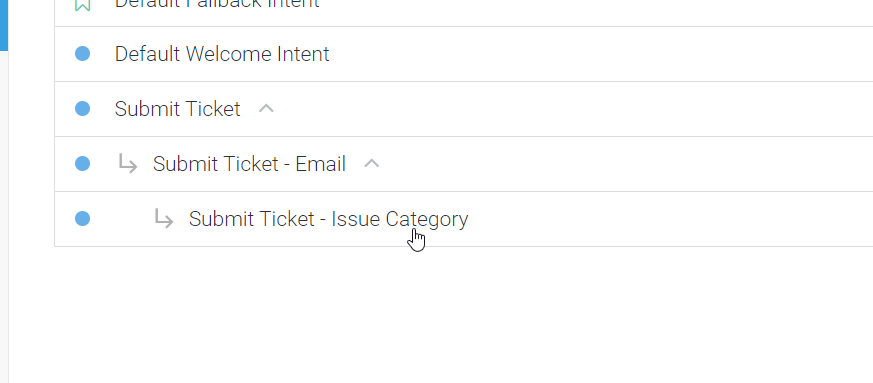

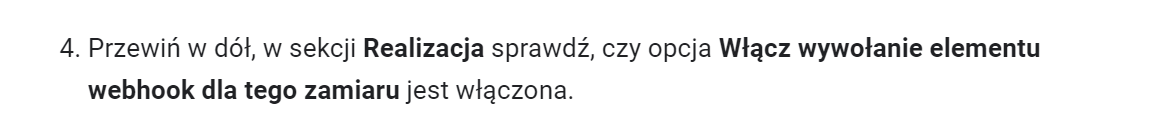

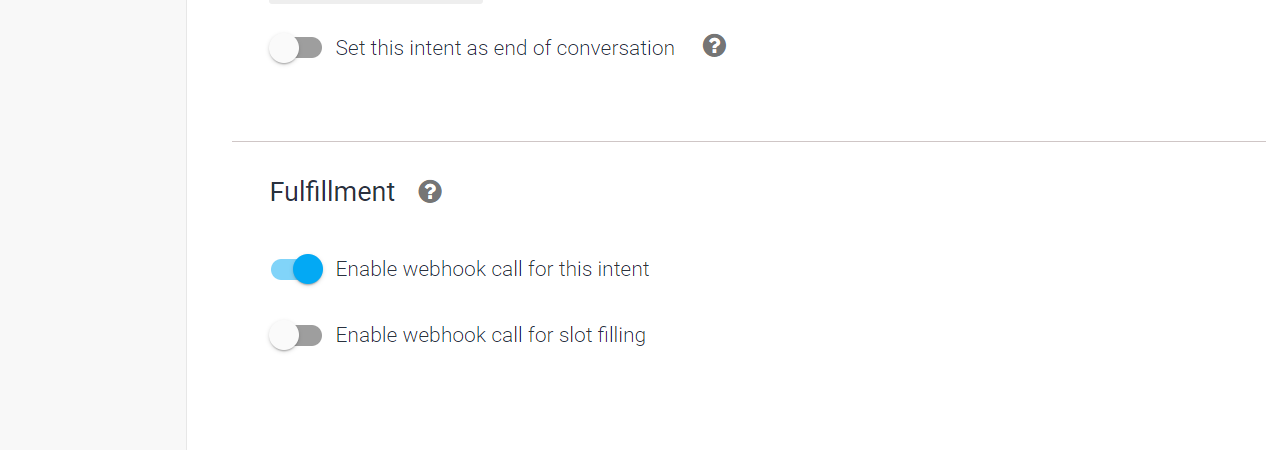

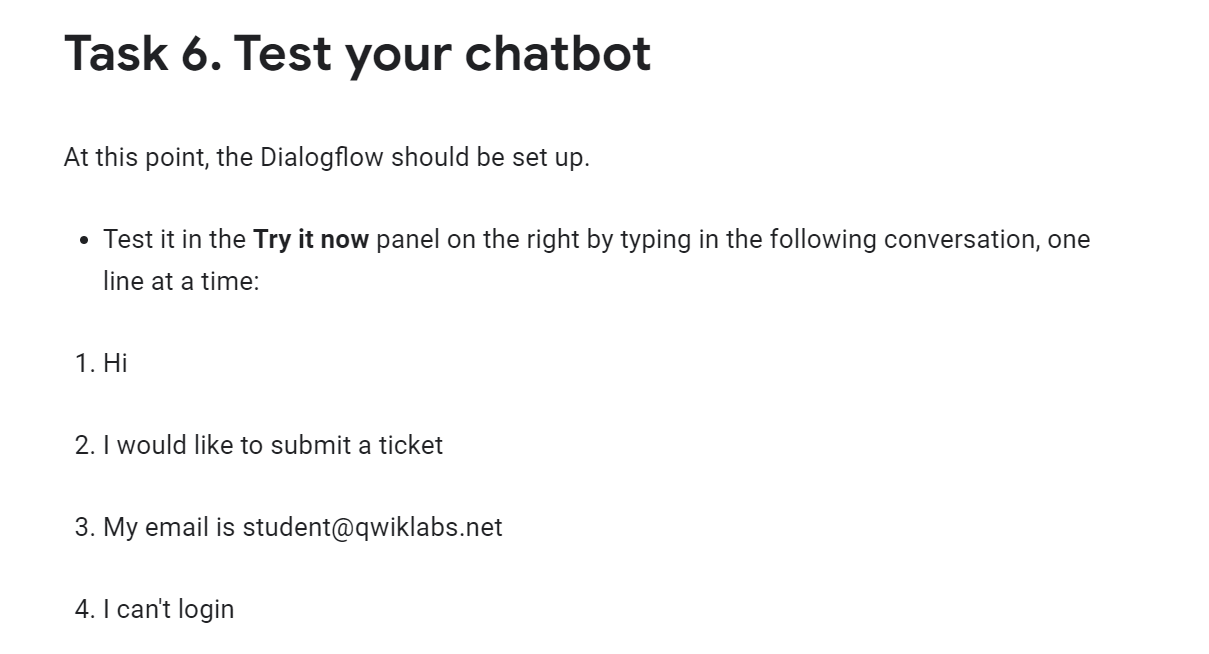

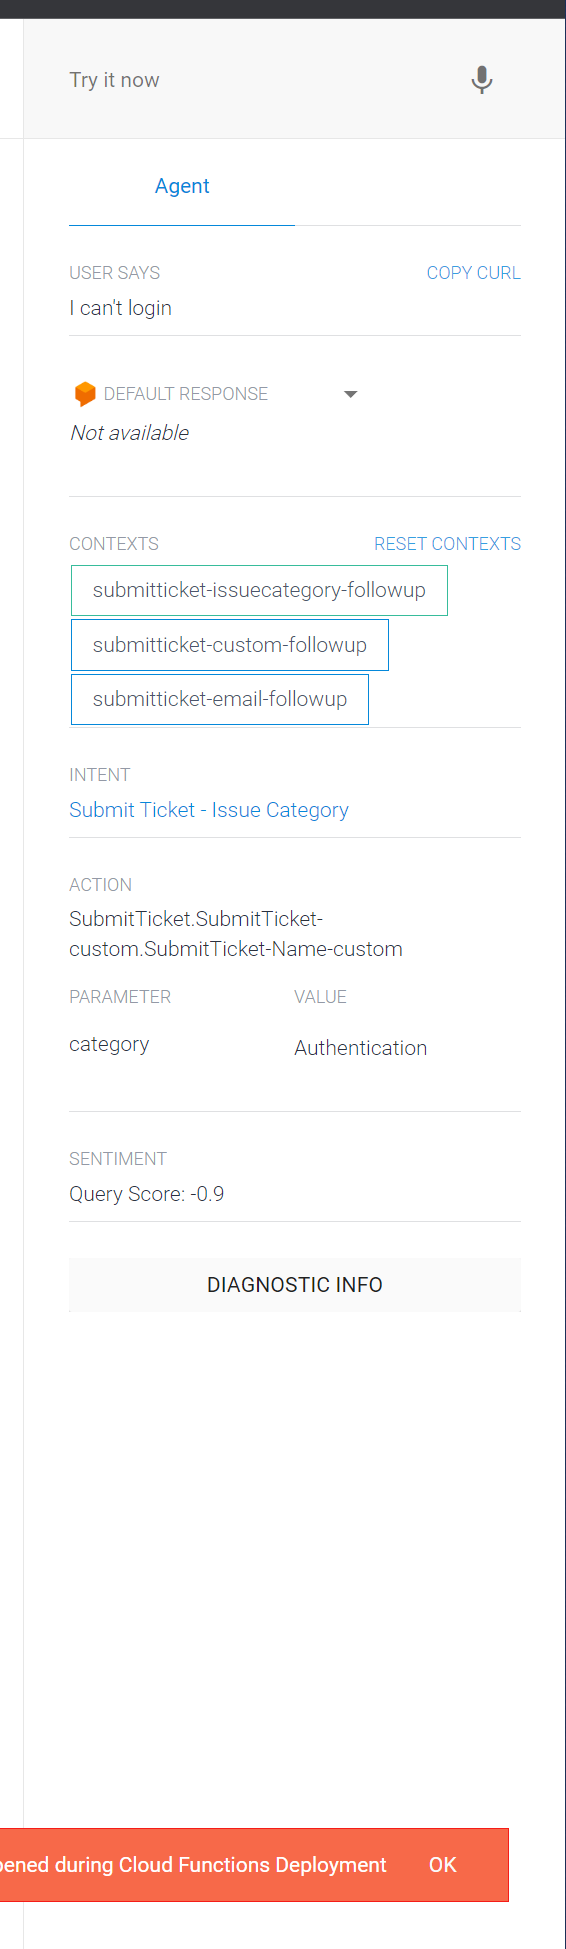

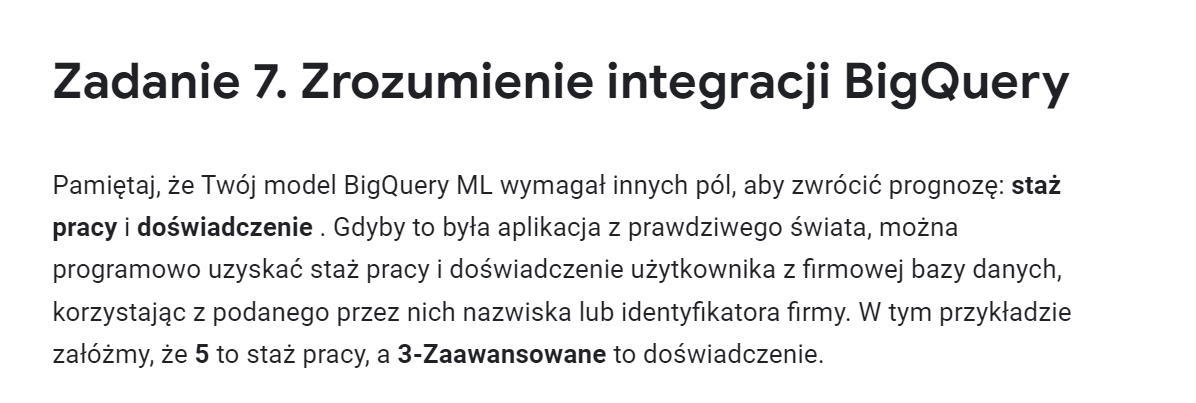

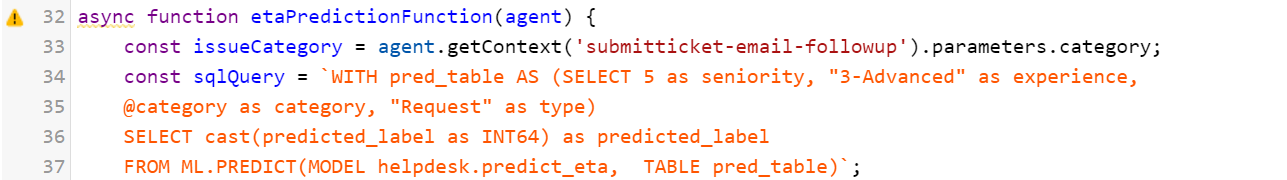

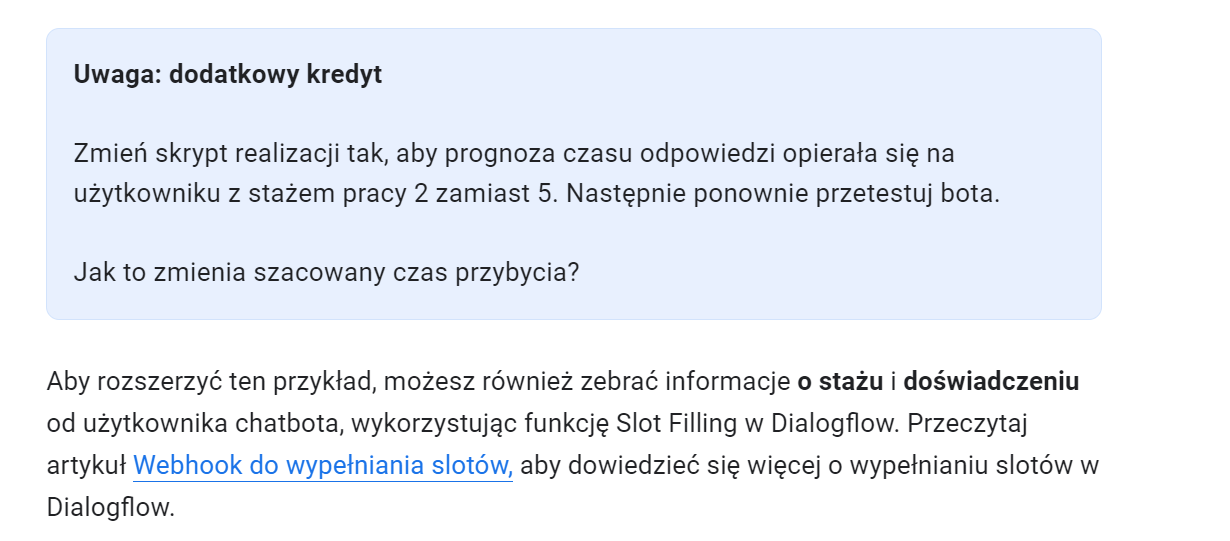

In [ ]:
# https://cloud.google.com/dialogflow/es/docs/fulfillment-webhook-slot-filling

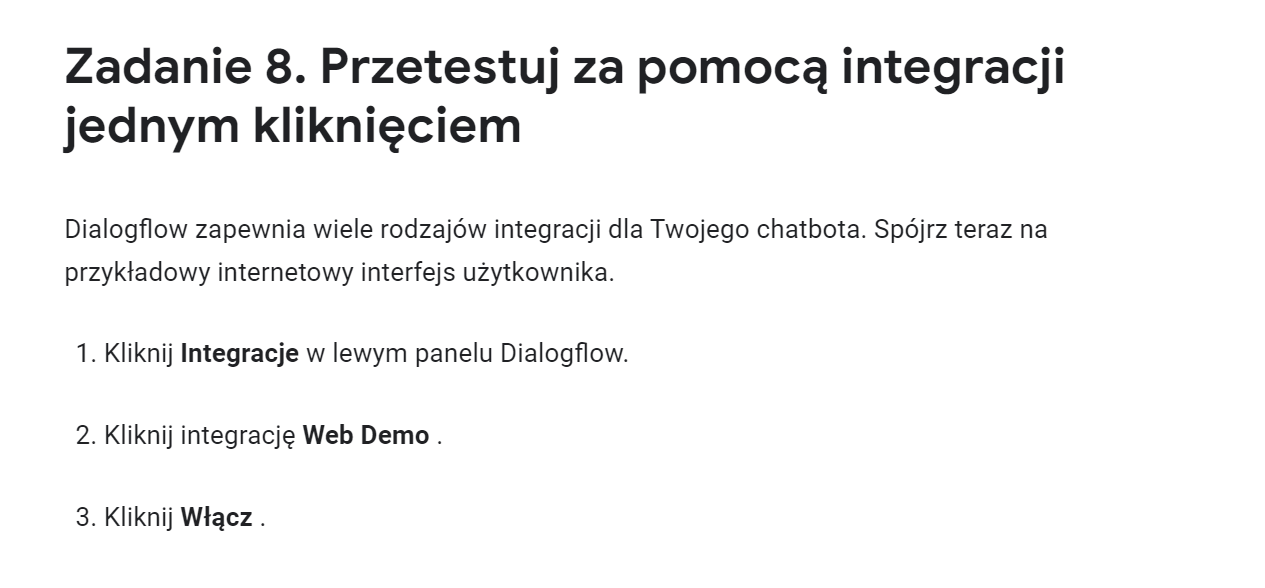

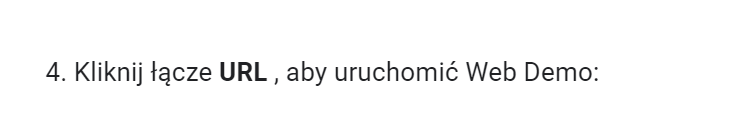

In [ ]:
# https://bot.dialogflow.com/52c7d90e-db3c-43c8-b1c1-c333860f16d8

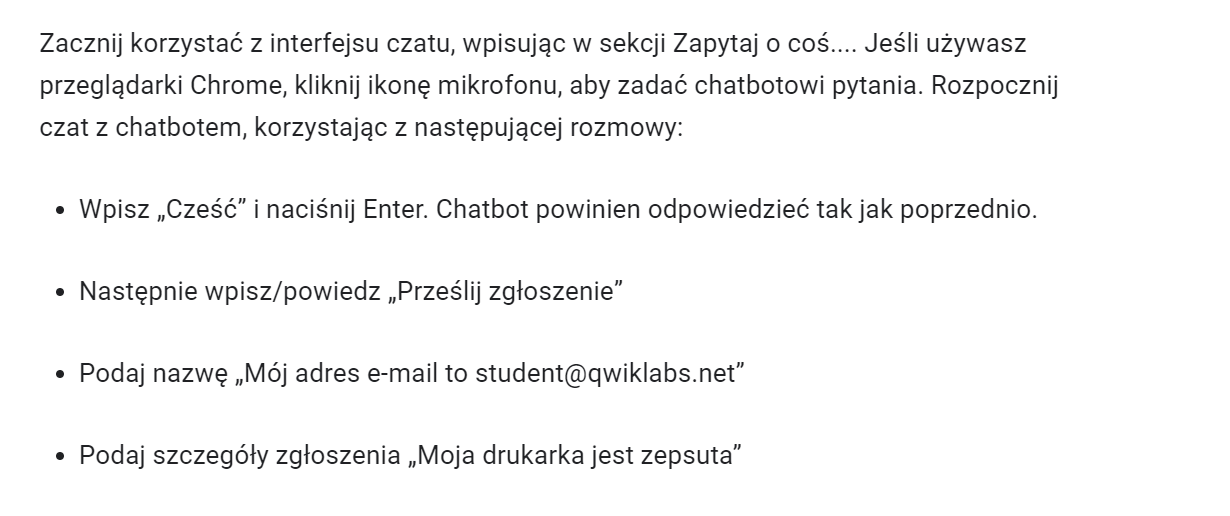

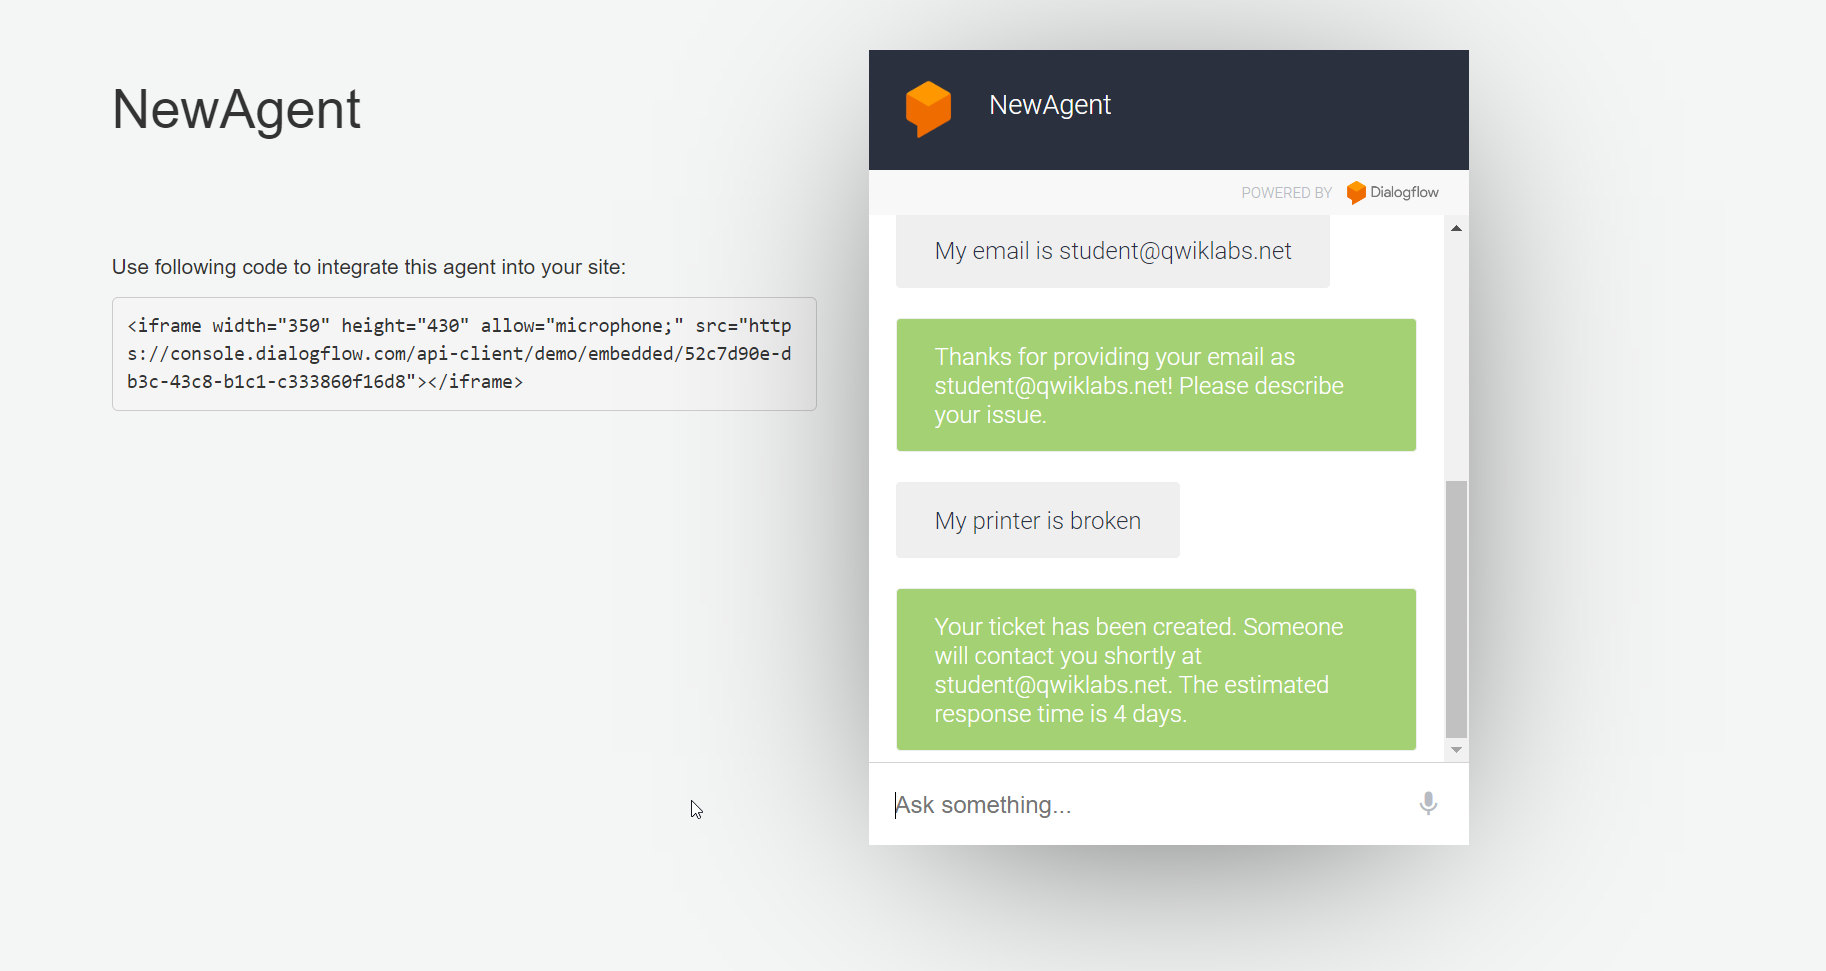